In [179]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import copy
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import pickle
import sys

import os



In [180]:

from datetime import datetime

# Get the current timestamp
current_timestamp = datetime.now()

# Format the timestamp in a human-readable form
folder_path = current_timestamp.strftime("%d_%H_%M")
fp = f"models/{folder_path}"
if not os.path.exists(fp):
	os.makedirs(fp)


In [181]:
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [182]:
df = pd.read_csv("drone/class_dict_seg.csv")

In [183]:
clients = [0 , 1 , 2]
no_clients = len(clients)
epochs = 100

In [184]:
image_path = "drone/dataset/semantic_drone_dataset/label_images_semantic"
original_image_path = "drone/dataset/semantic_drone_dataset/original_images"

In [185]:
files = os.listdir(image_path)

# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [
	file for file in files if file.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))
]
image_files = sorted(image_files)

# list o image_paths
image_list = []
# Print the list of image files
for image_file in image_files:
	image_list.append(image_path + "/" + image_file)


files_2 = os.listdir(original_image_path)
# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [
	file for file in files_2 if file.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))
]
image_files = sorted(image_files)

# list o image_paths
original_image_list = []
# Print the list of image files
for image_file in image_files:
	original_image_list.append(original_image_path + "/" + image_file)

In [186]:
IMAGE_PATH = "drone/dataset/semantic_drone_dataset/original_images"
MASK_PATH = "drone/dataset/semantic_drone_dataset/label_images_semantic"

In [187]:
n_classes = 23


def create_df():
	name = []
	for dirname, _, filenames in os.walk(IMAGE_PATH):
		for filename in filenames:
			name.append(filename.split(".")[0])

	return pd.DataFrame({"id": name}, index=np.arange(0, len(name)))


df = create_df()
print("Total Images: ", len(df))

Total Images:  400


In [188]:
df.iloc[0]

id    515
Name: 0, dtype: object

In [189]:
# spliting the data for traning , testing and validation
X_trainval, X_test = train_test_split(df["id"].values, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=42)

In [190]:
split_train = [X_train[i*len(X_train)//no_clients:(i+1)*len(X_train)//no_clients] for i in range(no_clients)]
split_val = [X_val[i*len(X_val)//no_clients:(i+1)*len(X_val)//no_clients] for i in range(no_clients)]

In [191]:
len(split_train[0])

102

In [192]:
class DroneDataset(Dataset):

	def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
		self.img_path = img_path
		self.mask_path = mask_path
		self.X = X
		self.transform = transform
		self.patches = patch
		self.mean = mean
		self.std = std

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		img_full_path = os.path.join(self.img_path, self.X[idx] + ".jpg")
		mask_full_path = os.path.join(self.mask_path, self.X[idx] + ".png")

		# Load the image and mask
		img = cv2.imread(img_full_path)
		if img is None:
			raise FileNotFoundError(f"Image not found at {img_full_path}")

		mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
		if mask is None:
			raise FileNotFoundError(f"Mask not found at {mask_full_path}")

		# Convert color from BGR to RGB
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

		if self.transform is not None:
			aug = self.transform(image=img, mask=mask)
			img = Image.fromarray(aug["image"])
			mask = aug["mask"]

		if self.transform is None:
			img = Image.fromarray(img)

		t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
		img = t(img)
		mask = torch.from_numpy(mask).long()

		if self.patches:
			img, mask = self.tiles(img, mask)

		return img, mask

	def tiles(self, img, mask):

		img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
		img_patches = img_patches.contiguous().view(3, -1, 512, 768)
		img_patches = img_patches.permute(1, 0, 2, 3)

		mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
		mask_patches = mask_patches.contiguous().view(-1, 512, 768)

		return img_patches, mask_patches

In [193]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose(
	[
		A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
		A.HorizontalFlip(),
		A.VerticalFlip(),
		A.GridDistortion(p=0.2),
		A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
		A.GaussNoise(),
	]
)

t_val = A.Compose(
	[
		A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
		A.HorizontalFlip(),
		A.GridDistortion(p=0.2),
	]
)

# datasets
train_set = DroneDataset(
	IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False
)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# dataloader
batch_size = 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [194]:
# datasets
train_loaders = []
val_loaders = [] 
for i in range(no_clients):
	b_train = split_train[i]
	b_val = split_val[i]
	train_set = DroneDataset(
		IMAGE_PATH, MASK_PATH, b_train, mean, std, t_train, patch=False
	)
	val_set = DroneDataset(IMAGE_PATH, MASK_PATH, b_val, mean, std, t_val, patch=False)

	# dataloader
	batch_size = 1

	train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
	train_loaders.append(train_loader)
	val_loaders.append(val_loader)

In [195]:
models = []
for i in range(no_clients):
	model = smp.Unet(
		encoder_name="resnet34",
		encoder_weights="imagenet",
		in_channels=3,
		classes=n_classes,
	)
	models.append(model)

In [196]:
def pixel_accuracy(output, mask):
	with torch.no_grad():
		output = torch.argmax(F.softmax(output, dim=1), dim=1)
		correct = torch.eq(output, mask).int()
		accuracy = float(correct.sum()) / float(correct.numel())
	return accuracy

In [197]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
	with torch.no_grad():
		pred_mask = F.softmax(pred_mask, dim=1)
		pred_mask = torch.argmax(pred_mask, dim=1)
		pred_mask = pred_mask.contiguous().view(-1)
		mask = mask.contiguous().view(-1)

		iou_per_class = []
		for clas in range(0, n_classes):  # loop per pixel class
			true_class = pred_mask == clas
			true_label = mask == clas

			if true_label.long().sum().item() == 0:  # no exist label in this loop
				iou_per_class.append(np.nan)
			else:
				intersect = (
					torch.logical_and(true_class, true_label).sum().float().item()
				)
				union = torch.logical_or(true_class, true_label).sum().float().item()

				iou = (intersect + smooth) / (union + smooth)
				iou_per_class.append(iou)
		return np.nanmean(iou_per_class)

In [198]:
import numpy as np
import matplotlib.pyplot as plt


def plot(pred_masks, true_masks):
	n_classes = len(np.unique(true_masks))  # Number of unique classes
	class_colors = plt.cm.tab20.colors  # Colors for different classes

	n_images = pred_masks.shape[0]  # Number of images

	# Create subplots outside the loop
	fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

	for i in range(n_images):
		im_pred = axes[i, 0].imshow(
			pred_masks[i, 0], cmap="tab20", vmin=0, vmax=n_classes - 1
		)  # Assuming single channel masks
		axes[i, 0].set_title("Predicted Mask")
		axes[i, 0].set_axis_off()
		fig.colorbar(im_pred, ax=axes[i, 0], label="Predicted Class")

		im_true = axes[i, 1].imshow(
			true_masks[i], cmap="tab20", vmin=0, vmax=n_classes - 1
		)
		axes[i, 1].set_title("True Mask")
		axes[i, 1].set_axis_off()
		fig.colorbar(im_true, ax=axes[i, 1], label="True Class")

	plt.tight_layout()
	plt.show()

In [199]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import time
from tqdm import tqdm
import learn2learn as l2l


def get_lr(optimizer):
	for param_group in optimizer.param_groups:
		return param_group["lr"]


def fit(
	epochs,
	model,
	train_loader,
	val_loader,
	criterion,
	optimizer,
	scheduler,
	patch=False,
	adaptation_steps=5,
	inner_lr=0.01,
):
	torch.cuda.empty_cache()
	train_losses = []
	test_losses = []
	val_iou = []
	val_acc = []
	train_iou = []
	train_acc = []
	lrs = []
	min_loss = np.inf
	decrease = 1
	not_improve = 0

	model.to(device)
	fit_time = time.time()
	for e in range(epochs):
		since = time.time()
		running_loss = 0
		iou_score = 0
		accuracy = 0

		# training loop
		model.train()
		for i, data in enumerate(tqdm(train_loader)):
			# training phase
			image_tiles, mask_tiles = data
			if patch:
				bs, n_tiles, c, h, w = image_tiles.size()
				image_tiles = image_tiles.view(-1, c, h, w)
				mask_tiles = mask_tiles.view(-1, h, w)

			image = image_tiles.to(device)
			mask = mask_tiles.to(device)

			# Meta-learning with MAML
			optimizer.zero_grad()

			# Clone the model for inner-loop updates
			learner = l2l.algorithms.MAML(model, lr=inner_lr).clone()

			# Inner loop: Adaptation
			for step in range(adaptation_steps):
				output = learner(image)
				loss = criterion(output, mask)
				learner.adapt(loss)

			# Meta-update
			output = learner(image)
			loss = criterion(output, mask)
			loss.backward()
			optimizer.step()

			# Step the learning rate
			lrs.append(get_lr(optimizer))
			scheduler.step()

			running_loss += loss.item()
			# Evaluation metrics
			iou_score += mIoU(output, mask)
			accuracy += pixel_accuracy(output, mask)

		# Validation loop
		model.eval()
		test_loss = 0
		test_accuracy = 0
		val_iou_score = 0
		with torch.no_grad():
			for i, data in enumerate(tqdm(val_loader)):
				image_tiles, mask_tiles = data
				if patch:
					bs, n_tiles, c, h, w = image_tiles.size()
					image_tiles = image_tiles.view(-1, c, h, w)
					mask_tiles = mask_tiles.view(-1, h, w)

				image = image_tiles.to(device)
				mask = mask_tiles.to(device)

				output = model(image)
				val_iou_score += mIoU(output, mask)
				test_accuracy += pixel_accuracy(output, mask)
				loss = criterion(output, mask)
				test_loss += loss.item()

		# Calculate mean for each batch
		train_losses.append(running_loss / len(train_loader))
		test_losses.append(test_loss / len(val_loader))

		if min_loss > (test_loss / len(val_loader)):
			print(
				"Loss Decreasing.. {:.3f} >> {:.3f} ".format(
					min_loss, (test_loss / len(val_loader))
				)
			)
			min_loss = test_loss / len(val_loader)
			decrease += 1
			if decrease % 5 == 0:
				print("saving model...")
				torch.save(
					model,
					"Unet-Mobilenet_v2_mIoU-{:.3f}.pt".format(
						val_iou_score / len(val_loader)
					),
				)

		if (test_loss / len(val_loader)) > min_loss:
			not_improve += 1
			min_loss = test_loss / len(val_loader)
			print(f"Loss Not Decrease for {not_improve} time")
			if not_improve == 7:
				print("Loss not decrease for 7 times, Stop Training")
				break

		# Update metrics
		val_iou.append(val_iou_score / len(val_loader))
		train_iou.append(iou_score / len(train_loader))
		train_acc.append(accuracy / len(train_loader))
		val_acc.append(test_accuracy / len(val_loader))
		print(
			"Epoch:{}/{}..".format(e + 1, epochs),
			"Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
			"Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
			"Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
			"Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
			"Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
			"Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
			"Time: {:.2f}m".format((time.time() - since) / 60),
		)

	history = {
		"train_loss": train_losses,
		"val_loss": test_losses,
		"train_miou": train_iou,
		"val_miou": val_iou,
		"train_acc": train_acc,
		"val_acc": val_acc,
		"lrs": lrs,
	}
	print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
	return history

In [200]:
# max_lr = 1e-3
# epoch = 2
# weight_decay = 1e-4

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# sched = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader)
# )

# history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

In [201]:
def fed_train(model):
	history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
	return model , history

In [202]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel()
ckks_params = {
	"scheme": "CKKS",
	"n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
	"scale": 2**30,  # All the encodings will use it for float->fixed point
	"qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()

In [203]:
def generate_diffie_hellman_parameters():
	parameters = dh.generate_parameters(generator=2, key_size=512)
	return parameters


def generate_diffie_hellman_keys(parameters):
	private_key = parameters.generate_private_key()
	public_key = private_key.public_key()
	return private_key, public_key


def derive_key(private_key, peer_public_key):
	shared_key = private_key.exchange(peer_public_key)
	derived_key = HKDF(
		algorithm=hashes.SHA256(),
		length=32,
		salt=None,
		info=b"handshake data",
	).derive(shared_key)
	return derived_key


def encrypt_message_AES(key, message):
	serialized_obj = pickle.dumps(message)
	cipher = Cipher(algorithms.AES(key), modes.ECB())
	encryptor = cipher.encryptor()
	padded_obj = serialized_obj + b" " * (16 - len(serialized_obj) % 16)
	ciphertext = encryptor.update(padded_obj) + encryptor.finalize()
	return ciphertext


def decrypt_message_AES(key, ciphertext):
	cipher = Cipher(algorithms.AES(key), modes.ECB())
	decryptor = cipher.decryptor()
	padded_obj = decryptor.update(ciphertext) + decryptor.finalize()
	serialized_obj = padded_obj.rstrip(b" ")
	obj = pickle.loads(serialized_obj)
	return obj


def setup_AES():
	num_clients = len(clients)
	parameters = generate_diffie_hellman_parameters()
	server_private_key, server_public_key = generate_diffie_hellman_keys(parameters)
	client_keys = [generate_diffie_hellman_keys(parameters) for _ in range(num_clients)]
	shared_keys = [
		derive_key(server_private_key, client_public_key)
		for _, client_public_key in client_keys
	]
	client_shared_keys = [
		derive_key(client_private_key, server_public_key)
		for client_private_key, _ in client_keys
	]

	return client_keys, shared_keys, client_shared_keys

client_keys, shared_keys, client_shared_keys = setup_AES()

In [204]:
def load_weights(model, weights):
	with torch.no_grad(): 
		for param, weight in zip(model.parameters(), weights):
			param.copy_(torch.tensor(weight))
	return model

In [205]:
def get_weights(model):
	return [param.cpu().detach().numpy() for param in model.parameters()]

In [206]:
def aggregate_wt(encypted_cwts):
	# cwts = []
	# for i, ecwt in enumerate(encypted_cwts):
	# 	cwts.append(decrypt_message_AES(shared_keys[i], ecwt))
	cwts = encypted_cwts
	resmodel = []
	for j in range(len(cwts[0])):  # for layers
		layer = []
		for k in range(len(cwts[0][j])):  # for chunks
			tmp = cwts[0][j][k].copy()
			for i in range(1, len(cwts)):  # for clients
				tmp = tmp + cwts[i][j][k]
			tmp = tmp / len(cwts)
			layer.append(tmp)
		resmodel.append(layer)

	res = [resmodel.copy() for _ in range(len(clients))]
	return res

In [207]:
def encrypt_wt(wtarray, i):
	cwt = []
	for layer in wtarray:
		flat_array = layer.astype(np.float64).flatten()

		chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)
		clayer = []
		for chunk in chunks:
			ptxt = HE.encodeFrac(chunk)
			ctxt = HE.encryptPtxt(ptxt)
			clayer.append(ctxt)
		cwt.append(clayer.copy())
	# ciphertext = encrypt_message_AES(client_shared_keys[i], cwt)
	# return ciphertext
	return cwt

In [208]:
def decrypt_weights(res):
	decrypted_weights = []
	for client_weights, model in zip(res, models):
		decrypted_client_weights = []
		wtarray = get_weights(model)
		for layer_weights, layer in zip(client_weights, wtarray):
			decrypted_layer_weights = []
			flat_array = layer.astype(np.float64).flatten()
			chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)
			for chunk, encrypted_chunk in zip(chunks, layer_weights):
				decrypted_chunk = HE.decryptFrac(encrypted_chunk)
				original_chunk_size = len(chunk)
				decrypted_chunk = decrypted_chunk[:original_chunk_size]
				decrypted_layer_weights.append(decrypted_chunk)
			decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
			decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
			decrypted_client_weights.append(decrypted_layer_weights)
		decrypted_weights.append(decrypted_client_weights)
	return decrypted_weights

In [209]:
max_lr = 0.01
weight_decay = 0.01

In [210]:
# histories = []
# cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
# print("Initial encrypted weights generated for all clients.")

# for e in range(epochs):
#     print(f"Epoch {e+1}/{epochs} started")
	
#     cwts = aggregate_wt(cwts)
#     print(f"Aggregated encrypted weights after epoch {e+1}")
	
#     wts = decrypt_weights(cwts)
#     print(f"Decrypted weights after aggregation for epoch {e+1}")
	
#     cwts = []
#     epoch_histories = []
	
#     for i in range(no_clients):
#         print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")
		
#         wt = wts[i]
#         model = load_weights(models[i], wt)
		
#         train_loader = train_loaders[i]
#         val_loader = val_loaders[i]
		
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader))
		
#         print(f"Client {i} Epoch {e+1} started")
		
#         history = fit(1, model, train_loader, val_loader, criterion, optimizer, sched)
		
#         epoch_histories.append(history)
#         print(f"Client {i} Epoch {e+1} completed with history: {history}")
		
#         wtarray = get_weights(model)
#         cwts.append(encrypt_wt(wtarray, i))
#         print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

#     histories.append(epoch_histories)
#     print(f"Epoch {e+1} completed and histories updated")

# print("Training completed.")


In [211]:
# from tqdm import tqdm

# histories = []
# previous_losses = {i: [] for i in range(no_clients)}

# cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
# print("Initial encrypted weights generated for all clients.")

# for e in tqdm(range(epochs), desc="Epochs", colour='green'):
#     print(f"Epoch {e+1}/{epochs} started")
	
#     cwts = aggregate_wt(cwts)
#     print(f"Aggregated encrypted weights after epoch {e+1}")
	
#     wts = decrypt_weights(cwts)
#     print(f"Decrypted weights after aggregation for epoch {e+1}")
	
#     cwts = []
#     epoch_histories = []
	
#     for i in range(no_clients):
#         print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")
		
#         wt = wts[i]
#         model = load_weights(models[i], wt)
		
#         train_loader = train_loaders[i]
#         val_loader = val_loaders[i]
		
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader))
		
#         print(f"Client {i} previous losses before epoch {e+1}: {previous_losses[i]}")
#         print(f"Client {i} Epoch {e+1} started")
		
#         history = fit(1, model, tqdm(train_loader, desc=f"Client {i} Training", colour='blue'), val_loader, criterion, optimizer, sched)
		
#         epoch_histories.append(history)
#         print(f"Client {i} Epoch {e+1} completed with history: {history}")
		
#         previous_losses[i].append({
#             'train_loss': history['train_loss'][-1],
#             'val_loss': history['val_loss'][-1]
#         })
#         print(f"Client {i} previous losses updated: {previous_losses[i]}")
		
#         wtarray = get_weights(model)
#         cwts.append(encrypt_wt(wtarray, i))
#         print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

#     histories.append(epoch_histories)
#     print(f"Epoch {e+1} completed and histories updated")

# print("Training completed.")



In [212]:
# # Plotting accuracy over time
# train_accuracies = {i: [] for i in range(no_clients)}
# val_accuracies = {i: [] for i in range(no_clients)}

# for epoch_histories in histories:
#     for i, history in enumerate(epoch_histories):
#         train_accuracies[i].append(history["train_accuracy"][-1])
#         val_accuracies[i].append(history["val_accuracy"][-1])

# plt.figure(figsize=(10, 6))

# for i in range(no_clients):
#     plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
#     plt.plot(val_accuracies[i], label=f"Client {i} Val Accuracy")

# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Training and Validation Accuracy Over Time")
# plt.legend()
# plt.grid(True)
# plt.show()

In [213]:

# for e, epoch_histories in enumerate(histories):
#     print(f"Epoch {e+1} histories:")
#     for i, history in enumerate(epoch_histories):
#         print(f"  Client {i}: {history}")

In [214]:
def fit(
	epochs,
	model,
	train_loader,
	val_loader,
	criterion,
	optimizer,
	scheduler,
	patch=False,
	adaptation_steps=5,
	inner_lr=0.01,
):
	torch.cuda.empty_cache()
	train_losses = []
	test_losses = []
	val_iou = []
	val_acc = []
	train_iou = []
	train_acc = []
	lrs = []
	min_loss = np.inf
	decrease = 1
	not_improve = 0

	model.to(device)
	fit_time = time.time()
	for e in range(epochs):
		since = time.time()
		running_loss = 0
		iou_score = 0
		accuracy = 0

		# training loop
		model.train()
		for i, data in enumerate(tqdm(train_loader)):
			# training phase
			image_tiles, mask_tiles = data
			if patch:
				bs, n_tiles, c, h, w = image_tiles.size()
				image_tiles = image_tiles.view(-1, c, h, w)
				mask_tiles = mask_tiles.view(-1, h, w)

			image = image_tiles.to(device)
			mask = mask_tiles.to(device)

			# Meta-learning with MAML
			optimizer.zero_grad()

			# Clone the model for inner-loop updates
			learner = l2l.algorithms.MAML(model, lr=inner_lr).clone()

			# Inner loop: Adaptation
			for step in range(adaptation_steps):
				output = learner(image)
				loss = criterion(output, mask)
				learner.adapt(loss)

			# Meta-update
			output = learner(image)
			loss = criterion(output, mask)
			loss.backward()
			optimizer.step()

			# Step the learning rate
			lrs.append(get_lr(optimizer))
			scheduler.step()

			running_loss += loss.item()
			# Evaluation metrics
			iou_score += mIoU(output, mask)
			accuracy += pixel_accuracy(output, mask)

		# Validation loop
		model.eval()
		test_loss = 0
		test_accuracy = 0
		val_iou_score = 0
		with torch.no_grad():
			for i, data in enumerate(tqdm(val_loader)):
				image_tiles, mask_tiles = data
				if patch:
					bs, n_tiles, c, h, w = image_tiles.size()
					image_tiles = image_tiles.view(-1, c, h, w)
					mask_tiles = mask_tiles.view(-1, h, w)

				image = image_tiles.to(device)
				mask = mask_tiles.to(device)

				output = model(image)
				val_iou_score += mIoU(output, mask)
				test_accuracy += pixel_accuracy(output, mask)
				loss = criterion(output, mask)
				test_loss += loss.item()

		# Calculate mean for each batch
		train_losses.append(running_loss / len(train_loader))
		test_losses.append(test_loss / len(val_loader))

		if min_loss > (test_loss / len(val_loader)):
			print(
				"Loss Decreasing.. {:.3f} >> {:.3f} ".format(
					min_loss, (test_loss / len(val_loader))
				)
			)
			min_loss = test_loss / len(val_loader)
			decrease += 1
			if decrease % 5 == 0:
				print("saving model...")
				torch.save(
					model,
					"Unet-Mobilenet_v2_mIoU-{:.3f}.pt".format(
						val_iou_score / len(val_loader)
					),
				)

		if (test_loss / len(val_loader)) > min_loss:
			not_improve += 1
			min_loss = test_loss / len(val_loader)
			print(f"Loss Not Decrease for {not_improve} time")
			if not_improve == 7:
				print("Loss not decrease for 7 times, Stop Training")
				break

		# Update metrics
		val_iou.append(val_iou_score / len(val_loader))
		train_iou.append(iou_score / len(train_loader))
		train_acc.append(accuracy / len(train_loader))
		val_acc.append(test_accuracy / len(val_loader))
		print(
			"Epoch:{}/{}..".format(e + 1, epochs),
			"Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
			"Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
			"Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
			"Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
			"Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
			"Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
			"Time: {:.2f}m".format((time.time() - since) / 60),
		)

	history = {
		"train_loss": train_losses,
		"val_loss": test_losses,
		"train_miou": train_iou,
		"val_miou": val_iou,
		"train_acc": train_acc,
		"val_acc": val_acc,
		"lrs": lrs,
	}
	print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
	return history

In [215]:
histories = []
previous_losses = {i: [] for i in range(no_clients)}

cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
print("Initial encrypted weights generated for all clients.")

for e in tqdm(range(epochs), desc="Epochs", colour="green"):
	print(f"Epoch {e+1}/{epochs} started")
	cwts = aggregate_wt(cwts)
	print(f"Aggregated encrypted weights after epoch {e+1}")
	wts = decrypt_weights(cwts)
	print(f"Decrypted weights after aggregation for epoch {e+1}")

	cwts = []
	epoch_histories = []

	for i in range(no_clients):
		print(f"Client {i} preparing for epoch {e+1}")
		wt = wts[i]
		model = load_weights(models[i], wt)
		if (e % 5 == 0) and i == 0:
			torch.save(model, f"{fp}/{e}_model.pth")
		train_loader = train_loaders[i]
		val_loader = val_loaders[i]

		criterion = nn.CrossEntropyLoss()
		optimizer = torch.optim.AdamW(
			model.parameters(), lr=max_lr, weight_decay=weight_decay
		)
		sched = torch.optim.lr_scheduler.OneCycleLR(
			optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader)
		)

		print(f"Client {i} previous losses: {previous_losses[i]}")
		history = fit(
			1,
			model,
			tqdm(train_loader, desc=f"Client {i} Training", colour="blue"),
			val_loader,
			criterion,
			optimizer,
			sched,
		)
		epoch_histories.append(history)

		previous_losses[i].append(
			{
				"train_loss": history["train_loss"][-1],
				"val_loss": history["val_loss"][-1],
				"train_acc": history["train_acc"][-1],
				"val_acc": history["val_acc"][-1],
			}
		)
		print(f"Client {i} updated losses: {previous_losses[i]}")

		wtarray = get_weights(model)
		cwts.append(encrypt_wt(wtarray, i))
		print(f"Client {i} weights encrypted for epoch {e+1}")

	histories.append(epoch_histories)
	print(f"Epoch {e+1} completed")

print("Training completed.")

Initial encrypted weights generated for all clients.


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 started
Aggregated encrypted weights after epoch 1
Decrypted weights after aggregation for epoch 1
Client 0 preparing for epoch 1
Client 0 previous losses: []









































































































100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Loss Decreasing.. inf >> 27.693 
Epoch:1/1.. Train Loss: 2.667.. Val Loss: 27.693.. Train mIoU:0.050.. Val mIoU: 0.032.. Train Acc:0.286.. Val Acc:0.209.. Time: 4.47m
Total time: 4.47 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}]
Client 0 weights encrypted for epoch 1
Client 1 preparing for epoch 1
Client 1 previous losses: []









































































































100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Loss Decreasing.. inf >> 2.364 
Epoch:1/1.. Train Loss: 1.619.. Val Loss: 2.364.. Train mIoU:0.111.. Val mIoU: 0.076.. Train Acc:0.602.. Val Acc:0.474.. Time: 4.50m
Total time: 4.50 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}]
Client 1 weights encrypted for epoch 1
Client 2 preparing for epoch 1
Client 2 previous losses: []









































































































100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


Loss Decreasing.. inf >> 2.685 
Epoch:1/1.. Train Loss: 2.154.. Val Loss: 2.685.. Train mIoU:0.105.. Val mIoU: 0.051.. Train Acc:0.500.. Val Acc:0.271.. Time: 4.53m
Total time: 4.53 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}]


Epochs:   1%|          | 1/100 [15:14<25:09:41, 914.96s/it]

Client 2 weights encrypted for epoch 1
Epoch 1 completed
Epoch 2/100 started
Aggregated encrypted weights after epoch 2
Decrypted weights after aggregation for epoch 2
Client 0 preparing for epoch 2
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}]









































































































100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


Loss Decreasing.. inf >> 2.213 
Epoch:1/1.. Train Loss: 1.486.. Val Loss: 2.213.. Train mIoU:0.111.. Val mIoU: 0.066.. Train Acc:0.595.. Val Acc:0.395.. Time: 4.61m
Total time: 4.61 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}]
Client 0 weights encrypted for epoch 2
Client 1 preparing for epoch 2
Client 1 previous losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}]









































































































100%|██████████| 18/18 [00:07<00:00,  2.32it/s]


Loss Decreasing.. inf >> 3.728 
Epoch:1/1.. Train Loss: 1.741.. Val Loss: 3.728.. Train mIoU:0.094.. Val mIoU: 0.035.. Train Acc:0.556.. Val Acc:0.313.. Time: 4.59m
Total time: 4.59 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}]
Client 1 weights encrypted for epoch 2
Client 2 preparing for epoch 2
Client 2 previous losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}]









































































































100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


Loss Decreasing.. inf >> 8.339 
Epoch:1/1.. Train Loss: 2.458.. Val Loss: 8.339.. Train mIoU:0.060.. Val mIoU: 0.048.. Train Acc:0.427.. Val Acc:0.338.. Time: 4.60m
Total time: 4.60 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}]


Epochs:   2%|▏         | 2/100 [30:46<25:10:18, 924.67s/it]

Client 2 weights encrypted for epoch 2
Epoch 2 completed
Epoch 3/100 started
Aggregated encrypted weights after epoch 3
Decrypted weights after aggregation for epoch 3
Client 0 preparing for epoch 3
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}]









































































































100%|██████████| 18/18 [00:07<00:00,  2.42it/s]


Loss Decreasing.. inf >> 4.145 
Epoch:1/1.. Train Loss: 1.643.. Val Loss: 4.145.. Train mIoU:0.103.. Val mIoU: 0.043.. Train Acc:0.579.. Val Acc:0.297.. Time: 4.60m
Total time: 4.60 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}]
Client 0 weights encrypted for epoch 3
Client 1 preparing for epoch 3
Client 1 previous losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}]









































































































100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


Loss Decreasing.. inf >> 3.691 
Epoch:1/1.. Train Loss: 1.962.. Val Loss: 3.691.. Train mIoU:0.076.. Val mIoU: 0.051.. Train Acc:0.488.. Val Acc:0.371.. Time: 4.59m
Total time: 4.59 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}]
Client 1 weights encrypted for epoch 3
Client 2 preparing for epoch 3
Client 2 previous losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}]









































































































100%|██████████| 18/18 [00:07<00:00,  2.55it/s]


Loss Decreasing.. inf >> 2.187 
Epoch:1/1.. Train Loss: 1.788.. Val Loss: 2.187.. Train mIoU:0.088.. Val mIoU: 0.074.. Train Acc:0.532.. Val Acc:0.405.. Time: 4.60m
Total time: 4.60 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}]


Epochs:   3%|▎         | 3/100 [46:17<24:59:45, 927.69s/it]

Client 2 weights encrypted for epoch 3
Epoch 3 completed
Epoch 4/100 started
Aggregated encrypted weights after epoch 4
Decrypted weights after aggregation for epoch 4
Client 0 preparing for epoch 4
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}]









































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


Loss Decreasing.. inf >> 38.982 
Epoch:1/1.. Train Loss: 1.480.. Val Loss: 38.982.. Train mIoU:0.119.. Val mIoU: 0.024.. Train Acc:0.606.. Val Acc:0.223.. Time: 4.50m
Total time: 4.50 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}]
Client 0 weights encrypted for epoch 4
Client 1 preparing for epoch 4
Client 1 previous losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.741150066256








































































































100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Loss Decreasing.. inf >> 5.959 
Epoch:1/1.. Train Loss: 2.118.. Val Loss: 5.959.. Train mIoU:0.086.. Val mIoU: 0.038.. Train Acc:0.516.. Val Acc:0.220.. Time: 4.50m
Total time: 4.50 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}]
Client 1 weights encrypted for epoch 4
Client 2 preparing for epoch 4
Client 2 previous losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786,








































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]


Loss Decreasing.. inf >> 14.183 
Epoch:1/1.. Train Loss: 1.600.. Val Loss: 14.183.. Train mIoU:0.106.. Val mIoU: 0.045.. Train Acc:0.572.. Val Acc:0.259.. Time: 4.49m
Total time: 4.49 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}]


Epochs:   4%|▍         | 4/100 [1:01:30<24:34:54, 921.82s/it]

Client 2 weights encrypted for epoch 4
Epoch 4 completed
Epoch 5/100 started
Aggregated encrypted weights after epoch 5
Decrypted weights after aggregation for epoch 5
Client 0 preparing for epoch 5
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}]









































































































100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


Loss Decreasing.. inf >> 14.561 
Epoch:1/1.. Train Loss: 1.836.. Val Loss: 14.561.. Train mIoU:0.098.. Val mIoU: 0.033.. Train Acc:0.558.. Val Acc:0.278.. Time: 4.58m
Total time: 4.58 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}]
Client 0 weights encrypted for epoch 5
Client 1 preparing for epoch 5
Client 1 previous losses: [{'train_loss': 1.618775751076








































































































100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


Loss Decreasing.. inf >> 4.112 
Epoch:1/1.. Train Loss: 1.696.. Val Loss: 4.112.. Train mIoU:0.101.. Val mIoU: 0.052.. Train Acc:0.589.. Val Acc:0.240.. Time: 4.59m
Total time: 4.59 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}]
Client 1 weights encrypted for epoch 5
Client 2 preparing for epoch 5
Client 2 previous losses: [{'train_loss': 2.1538937033391465








































































































100%|██████████| 18/18 [00:07<00:00,  2.55it/s]


Loss Decreasing.. inf >> 4.244 
Epoch:1/1.. Train Loss: 2.171.. Val Loss: 4.244.. Train mIoU:0.083.. Val mIoU: 0.036.. Train Acc:0.491.. Val Acc:0.365.. Time: 4.59m
Total time: 4.59 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}]


Epochs:   5%|▌         | 5/100 [1:16:59<24:23:38, 924.41s/it]

Client 2 weights encrypted for epoch 5
Epoch 5 completed
Epoch 6/100 started
Aggregated encrypted weights after epoch 6
Decrypted weights after aggregation for epoch 6
Client 0 preparing for epoch 6
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}]









































































































100%|██████████| 18/18 [00:06<00:00,  2.76it/s]


Loss Decreasing.. inf >> 1.947 
Epoch:1/1.. Train Loss: 1.584.. Val Loss: 1.947.. Train mIoU:0.104.. Val mIoU: 0.075.. Train Acc:0.582.. Val Acc:0.460.. Time: 4.49m
Total time: 4.49 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.78it/s]


Loss Decreasing.. inf >> 16.630 
Epoch:1/1.. Train Loss: 1.469.. Val Loss: 16.630.. Train mIoU:0.125.. Val mIoU: 0.020.. Train Acc:0.629.. Val Acc:0.102.. Time: 4.49m
Total time: 4.49 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.77it/s]


Loss Decreasing.. inf >> 3.625 
Epoch:1/1.. Train Loss: 1.843.. Val Loss: 3.625.. Train mIoU:0.092.. Val mIoU: 0.022.. Train Acc:0.524.. Val Acc:0.129.. Time: 4.50m
Total time: 4.50 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}]


Epochs:   6%|▌         | 6/100 [1:32:11<24:01:45, 920.27s/it]

Client 2 weights encrypted for epoch 6
Epoch 6 completed
Epoch 7/100 started
Aggregated encrypted weights after epoch 7
Decrypted weights after aggregation for epoch 7
Client 0 preparing for epoch 7
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.








































































































100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


Loss Decreasing.. inf >> 11.617 
Epoch:1/1.. Train Loss: 2.462.. Val Loss: 11.617.. Train mIoU:0.099.. Val mIoU: 0.048.. Train Acc:0.537.. Val Acc:0.307.. Time: 4.58m
Total time: 4.58 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


Loss Decreasing.. inf >> 2.628 
Epoch:1/1.. Train Loss: 1.505.. Val Loss: 2.628.. Train mIoU:0.108.. Val mIoU: 0.060.. Train Acc:0.621.. Val Acc:0.347.. Time: 4.59m
Total time: 4.59 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


Loss Decreasing.. inf >> 378.934 
Epoch:1/1.. Train Loss: 2.693.. Val Loss: 378.934.. Train mIoU:0.068.. Val mIoU: 0.045.. Train Acc:0.446.. Val Acc:0.239.. Time: 4.58m
Total time: 4.58 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}

Epochs:   7%|▋         | 7/100 [1:47:40<23:50:49, 923.11s/it]

Client 2 weights encrypted for epoch 7
Epoch 7 completed
Epoch 8/100 started
Aggregated encrypted weights after epoch 8
Decrypted weights after aggregation for epoch 8
Client 0 preparing for epoch 8
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.








































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]


Loss Decreasing.. inf >> 1.794 
Epoch:1/1.. Train Loss: 1.561.. Val Loss: 1.794.. Train mIoU:0.109.. Val mIoU: 0.072.. Train Acc:0.609.. Val Acc:0.453.. Time: 4.50m
Total time: 4.50 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.80it/s]


Loss Decreasing.. inf >> 2.589 
Epoch:1/1.. Train Loss: 1.592.. Val Loss: 2.589.. Train mIoU:0.103.. Val mIoU: 0.091.. Train Acc:0.600.. Val Acc:0.380.. Time: 4.48m
Total time: 4.48 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


Loss Decreasing.. inf >> 2.679 
Epoch:1/1.. Train Loss: 1.959.. Val Loss: 2.679.. Train mIoU:0.077.. Val mIoU: 0.061.. Train Acc:0.520.. Val Acc:0.417.. Time: 4.49m
Total time: 4.49 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:   8%|▊         | 8/100 [2:02:52<23:29:54, 919.51s/it]

Client 2 weights encrypted for epoch 8
Epoch 8 completed
Epoch 9/100 started
Aggregated encrypted weights after epoch 9
Decrypted weights after aggregation for epoch 9
Client 0 preparing for epoch 9
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.








































































































100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


Loss Decreasing.. inf >> 7.683 
Epoch:1/1.. Train Loss: 1.806.. Val Loss: 7.683.. Train mIoU:0.121.. Val mIoU: 0.045.. Train Acc:0.568.. Val Acc:0.149.. Time: 4.51m
Total time: 4.51 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Loss Decreasing.. inf >> 3.034 
Epoch:1/1.. Train Loss: 2.217.. Val Loss: 3.034.. Train mIoU:0.092.. Val mIoU: 0.029.. Train Acc:0.528.. Val Acc:0.119.. Time: 4.52m
Total time: 4.52 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


Loss Decreasing.. inf >> 2.502 
Epoch:1/1.. Train Loss: 1.524.. Val Loss: 2.502.. Train mIoU:0.104.. Val mIoU: 0.093.. Train Acc:0.586.. Val Acc:0.481.. Time: 4.50m
Total time: 4.50 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:   9%|▉         | 9/100 [2:18:08<23:12:48, 918.33s/it]

Client 2 weights encrypted for epoch 9
Epoch 9 completed
Epoch 10/100 started
Aggregated encrypted weights after epoch 10
Decrypted weights after aggregation for epoch 10
Client 0 preparing for epoch 10
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc'








































































































100%|██████████| 18/18 [00:06<00:00,  2.77it/s]


Loss Decreasing.. inf >> 2.770 
Epoch:1/1.. Train Loss: 1.648.. Val Loss: 2.770.. Train mIoU:0.105.. Val mIoU: 0.042.. Train Acc:0.616.. Val Acc:0.277.. Time: 4.51m
Total time: 4.51 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Loss Decreasing.. inf >> 8.190 
Epoch:1/1.. Train Loss: 1.368.. Val Loss: 8.190.. Train mIoU:0.146.. Val mIoU: 0.077.. Train Acc:0.656.. Val Acc:0.267.. Time: 4.50m
Total time: 4.50 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]


Loss Decreasing.. inf >> 1.913 
Epoch:1/1.. Train Loss: 1.549.. Val Loss: 1.913.. Train mIoU:0.118.. Val mIoU: 0.108.. Train Acc:0.594.. Val Acc:0.404.. Time: 4.48m
Total time: 4.48 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  10%|█         | 10/100 [2:33:21<22:55:00, 916.67s/it]

Client 2 weights encrypted for epoch 10
Epoch 10 completed
Epoch 11/100 started
Aggregated encrypted weights after epoch 11
Decrypted weights after aggregation for epoch 11
Client 0 preparing for epoch 11
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.74it/s]


Loss Decreasing.. inf >> 2.221 
Epoch:1/1.. Train Loss: 1.640.. Val Loss: 2.221.. Train mIoU:0.117.. Val mIoU: 0.087.. Train Acc:0.593.. Val Acc:0.447.. Time: 4.52m
Total time: 4.52 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.77it/s]


Loss Decreasing.. inf >> 4.049 
Epoch:1/1.. Train Loss: 1.629.. Val Loss: 4.049.. Train mIoU:0.106.. Val mIoU: 0.018.. Train Acc:0.602.. Val Acc:0.132.. Time: 4.52m
Total time: 4.52 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Loss Decreasing.. inf >> 4.387 
Epoch:1/1.. Train Loss: 1.666.. Val Loss: 4.387.. Train mIoU:0.107.. Val mIoU: 0.019.. Train Acc:0.555.. Val Acc:0.119.. Time: 4.52m
Total time: 4.52 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  11%|█         | 11/100 [2:48:38<22:39:53, 916.78s/it]

Client 2 weights encrypted for epoch 11
Epoch 11 completed
Epoch 12/100 started
Aggregated encrypted weights after epoch 12
Decrypted weights after aggregation for epoch 12
Client 0 preparing for epoch 12
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.55it/s]


Loss Decreasing.. inf >> 3.516 
Epoch:1/1.. Train Loss: 1.910.. Val Loss: 3.516.. Train mIoU:0.107.. Val mIoU: 0.032.. Train Acc:0.582.. Val Acc:0.195.. Time: 4.58m
Total time: 4.58 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


Loss Decreasing.. inf >> 4.199 
Epoch:1/1.. Train Loss: 1.390.. Val Loss: 4.199.. Train mIoU:0.125.. Val mIoU: 0.049.. Train Acc:0.628.. Val Acc:0.302.. Time: 4.59m
Total time: 4.59 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


Loss Decreasing.. inf >> 2.292 
Epoch:1/1.. Train Loss: 1.716.. Val Loss: 2.292.. Train mIoU:0.096.. Val mIoU: 0.080.. Train Acc:0.556.. Val Acc:0.419.. Time: 4.57m
Total time: 4.57 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  12%|█▏        | 12/100 [3:04:05<22:29:28, 920.09s/it]

Client 2 weights encrypted for epoch 12
Epoch 12 completed
Epoch 13/100 started
Aggregated encrypted weights after epoch 13
Decrypted weights after aggregation for epoch 13
Client 0 preparing for epoch 13
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


Loss Decreasing.. inf >> 339.838 
Epoch:1/1.. Train Loss: 2.412.. Val Loss: 339.838.. Train mIoU:0.090.. Val mIoU: 0.020.. Train Acc:0.481.. Val Acc:0.072.. Time: 4.59m
Total time: 4.59 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.459563078703








































































































100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Loss Decreasing.. inf >> 9.124 
Epoch:1/1.. Train Loss: 1.705.. Val Loss: 9.124.. Train mIoU:0.117.. Val mIoU: 0.023.. Train Acc:0.574.. Val Acc:0.099.. Time: 4.51m
Total time: 4.51 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Loss Decreasing.. inf >> 4.552 
Epoch:1/1.. Train Loss: 1.815.. Val Loss: 4.552.. Train mIoU:0.102.. Val mIoU: 0.035.. Train Acc:0.558.. Val Acc:0.206.. Time: 4.50m
Total time: 4.50 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  13%|█▎        | 13/100 [3:19:25<22:13:58, 919.98s/it]

Client 2 weights encrypted for epoch 13
Epoch 13 completed
Epoch 14/100 started
Aggregated encrypted weights after epoch 14
Decrypted weights after aggregation for epoch 14
Client 0 preparing for epoch 14
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


Loss Decreasing.. inf >> 2.662 
Epoch:1/1.. Train Loss: 1.444.. Val Loss: 2.662.. Train mIoU:0.141.. Val mIoU: 0.063.. Train Acc:0.645.. Val Acc:0.293.. Time: 4.59m
Total time: 4.59 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.79it/s]


Loss Decreasing.. inf >> 2.051 
Epoch:1/1.. Train Loss: 1.370.. Val Loss: 2.051.. Train mIoU:0.135.. Val mIoU: 0.091.. Train Acc:0.655.. Val Acc:0.469.. Time: 4.50m
Total time: 4.50 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.74it/s]


Loss Decreasing.. inf >> 239.796 
Epoch:1/1.. Train Loss: 1.826.. Val Loss: 239.796.. Train mIoU:0.093.. Val mIoU: 0.053.. Train Acc:0.543.. Val Acc:0.308.. Time: 4.49m
Total time: 4.49 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}

Epochs:  14%|█▍        | 14/100 [3:34:44<21:58:04, 919.58s/it]

Client 2 weights encrypted for epoch 14
Epoch 14 completed
Epoch 15/100 started
Aggregated encrypted weights after epoch 15
Decrypted weights after aggregation for epoch 15
Client 0 preparing for epoch 15
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Loss Decreasing.. inf >> 2.282 
Epoch:1/1.. Train Loss: 1.386.. Val Loss: 2.282.. Train mIoU:0.131.. Val mIoU: 0.055.. Train Acc:0.654.. Val Acc:0.402.. Time: 4.55m
Total time: 4.55 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]


Loss Decreasing.. inf >> 15.265 
Epoch:1/1.. Train Loss: 3.650.. Val Loss: 15.265.. Train mIoU:0.092.. Val mIoU: 0.037.. Train Acc:0.495.. Val Acc:0.311.. Time: 4.48m
Total time: 4.48 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 2.026 
Epoch:1/1.. Train Loss: 1.625.. Val Loss: 2.026.. Train mIoU:0.109.. Val mIoU: 0.087.. Train Acc:0.582.. Val Acc:0.468.. Time: 4.45m
Total time: 4.45 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  15%|█▌        | 15/100 [3:49:57<21:39:55, 917.60s/it]

Client 2 weights encrypted for epoch 15
Epoch 15 completed
Epoch 16/100 started
Aggregated encrypted weights after epoch 16
Decrypted weights after aggregation for epoch 16
Client 0 preparing for epoch 16
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 7.121 
Epoch:1/1.. Train Loss: 3.131.. Val Loss: 7.121.. Train mIoU:0.091.. Val mIoU: 0.039.. Train Acc:0.513.. Val Acc:0.264.. Time: 4.47m
Total time: 4.47 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]


Loss Decreasing.. inf >> 3.993 
Epoch:1/1.. Train Loss: 1.428.. Val Loss: 3.993.. Train mIoU:0.134.. Val mIoU: 0.083.. Train Acc:0.641.. Val Acc:0.350.. Time: 4.50m
Total time: 4.50 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 2.083 
Epoch:1/1.. Train Loss: 1.609.. Val Loss: 2.083.. Train mIoU:0.103.. Val mIoU: 0.069.. Train Acc:0.565.. Val Acc:0.434.. Time: 4.48m
Total time: 4.48 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  16%|█▌        | 16/100 [4:05:07<21:21:38, 915.46s/it]

Client 2 weights encrypted for epoch 16
Epoch 16 completed
Epoch 17/100 started
Aggregated encrypted weights after epoch 17
Decrypted weights after aggregation for epoch 17
Client 0 preparing for epoch 17
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:05<00:00,  3.00it/s]


Loss Decreasing.. inf >> 3.993 
Epoch:1/1.. Train Loss: 1.827.. Val Loss: 3.993.. Train mIoU:0.106.. Val mIoU: 0.031.. Train Acc:0.568.. Val Acc:0.239.. Time: 4.43m
Total time: 4.43 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 2.715 
Epoch:1/1.. Train Loss: 1.278.. Val Loss: 2.715.. Train mIoU:0.145.. Val mIoU: 0.096.. Train Acc:0.658.. Val Acc:0.330.. Time: 4.42m
Total time: 4.42 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:05<00:00,  3.04it/s]


Loss Decreasing.. inf >> 7.617 
Epoch:1/1.. Train Loss: 2.435.. Val Loss: 7.617.. Train mIoU:0.103.. Val mIoU: 0.061.. Train Acc:0.513.. Val Acc:0.349.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  17%|█▋        | 17/100 [4:20:08<21:00:19, 911.08s/it]

Client 2 weights encrypted for epoch 17
Epoch 17 completed
Epoch 18/100 started
Aggregated encrypted weights after epoch 18
Decrypted weights after aggregation for epoch 18
Client 0 preparing for epoch 18
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 14.730 
Epoch:1/1.. Train Loss: 5.714.. Val Loss: 14.730.. Train mIoU:0.081.. Val mIoU: 0.031.. Train Acc:0.396.. Val Acc:0.208.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 11.302 
Epoch:1/1.. Train Loss: 2.561.. Val Loss: 11.302.. Train mIoU:0.103.. Val mIoU: 0.041.. Train Acc:0.504.. Val Acc:0.210.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 22.888 
Epoch:1/1.. Train Loss: 4.978.. Val Loss: 22.888.. Train mIoU:0.049.. Val mIoU: 0.017.. Train Acc:0.278.. Val Acc:0.143.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  18%|█▊        | 18/100 [4:35:11<20:41:47, 908.62s/it]

Client 2 weights encrypted for epoch 18
Epoch 18 completed
Epoch 19/100 started
Aggregated encrypted weights after epoch 19
Decrypted weights after aggregation for epoch 19
Client 0 preparing for epoch 19
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 9.797 
Epoch:1/1.. Train Loss: 3.147.. Val Loss: 9.797.. Train mIoU:0.098.. Val mIoU: 0.035.. Train Acc:0.486.. Val Acc:0.143.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 3.793 
Epoch:1/1.. Train Loss: 2.733.. Val Loss: 3.793.. Train mIoU:0.091.. Val mIoU: 0.047.. Train Acc:0.468.. Val Acc:0.267.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:05<00:00,  3.02it/s]


Loss Decreasing.. inf >> 16.242 
Epoch:1/1.. Train Loss: 2.168.. Val Loss: 16.242.. Train mIoU:0.107.. Val mIoU: 0.056.. Train Acc:0.517.. Val Acc:0.142.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  19%|█▉        | 19/100 [4:50:14<20:24:08, 906.78s/it]

Client 2 weights encrypted for epoch 19
Epoch 19 completed
Epoch 20/100 started
Aggregated encrypted weights after epoch 20
Decrypted weights after aggregation for epoch 20
Client 0 preparing for epoch 20
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Loss Decreasing.. inf >> 14.125 
Epoch:1/1.. Train Loss: 2.803.. Val Loss: 14.125.. Train mIoU:0.091.. Val mIoU: 0.044.. Train Acc:0.493.. Val Acc:0.272.. Time: 4.54m
Total time: 4.54 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 4.951 
Epoch:1/1.. Train Loss: 2.123.. Val Loss: 4.951.. Train mIoU:0.104.. Val mIoU: 0.028.. Train Acc:0.497.. Val Acc:0.146.. Time: 4.53m
Total time: 4.53 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 7.364 
Epoch:1/1.. Train Loss: 2.628.. Val Loss: 7.364.. Train mIoU:0.097.. Val mIoU: 0.059.. Train Acc:0.484.. Val Acc:0.187.. Time: 4.46m
Total time: 4.46 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  20%|██        | 20/100 [5:05:29<20:12:35, 909.45s/it]

Client 2 weights encrypted for epoch 20
Epoch 20 completed
Epoch 21/100 started
Aggregated encrypted weights after epoch 21
Decrypted weights after aggregation for epoch 21
Client 0 preparing for epoch 21
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 420.021 
Epoch:1/1.. Train Loss: 1.547.. Val Loss: 420.021.. Train mIoU:0.117.. Val mIoU: 0.044.. Train Acc:0.615.. Val Acc:0.193.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.459563078703








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 354.739 
Epoch:1/1.. Train Loss: 1.659.. Val Loss: 354.739.. Train mIoU:0.117.. Val mIoU: 0.060.. Train Acc:0.599.. Val Acc:0.299.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.1017858658794








































































































100%|██████████| 18/18 [00:05<00:00,  3.03it/s]


Loss Decreasing.. inf >> 2.352 
Epoch:1/1.. Train Loss: 1.616.. Val Loss: 2.352.. Train mIoU:0.115.. Val mIoU: 0.093.. Train Acc:0.568.. Val Acc:0.351.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  21%|██        | 21/100 [5:20:32<19:54:45, 907.41s/it]

Client 2 weights encrypted for epoch 21
Epoch 21 completed
Epoch 22/100 started
Aggregated encrypted weights after epoch 22
Decrypted weights after aggregation for epoch 22
Client 0 preparing for epoch 22
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 2.565 
Epoch:1/1.. Train Loss: 1.275.. Val Loss: 2.565.. Train mIoU:0.140.. Val mIoU: 0.064.. Train Acc:0.651.. Val Acc:0.297.. Time: 4.52m
Total time: 4.52 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Loss Decreasing.. inf >> 17.116 
Epoch:1/1.. Train Loss: 1.325.. Val Loss: 17.116.. Train mIoU:0.141.. Val mIoU: 0.081.. Train Acc:0.651.. Val Acc:0.299.. Time: 4.53m
Total time: 4.53 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 23.490 
Epoch:1/1.. Train Loss: 1.462.. Val Loss: 23.490.. Train mIoU:0.121.. Val mIoU: 0.090.. Train Acc:0.598.. Val Acc:0.385.. Time: 4.45m
Total time: 4.45 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  22%|██▏       | 22/100 [5:35:45<19:41:54, 909.17s/it]

Client 2 weights encrypted for epoch 22
Epoch 22 completed
Epoch 23/100 started
Aggregated encrypted weights after epoch 23
Decrypted weights after aggregation for epoch 23
Client 0 preparing for epoch 23
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 138.187 
Epoch:1/1.. Train Loss: 2.685.. Val Loss: 138.187.. Train mIoU:0.114.. Val mIoU: 0.021.. Train Acc:0.458.. Val Acc:0.072.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.459563078703








































































































100%|██████████| 18/18 [00:06<00:00,  3.00it/s]


Loss Decreasing.. inf >> 2.793 
Epoch:1/1.. Train Loss: 1.334.. Val Loss: 2.793.. Train mIoU:0.126.. Val mIoU: 0.064.. Train Acc:0.641.. Val Acc:0.459.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:05<00:00,  3.03it/s]


Loss Decreasing.. inf >> 184.773 
Epoch:1/1.. Train Loss: 1.502.. Val Loss: 184.773.. Train mIoU:0.123.. Val mIoU: 0.080.. Train Acc:0.596.. Val Acc:0.463.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}

Epochs:  23%|██▎       | 23/100 [5:50:48<19:24:18, 907.25s/it]

Client 2 weights encrypted for epoch 23
Epoch 23 completed
Epoch 24/100 started
Aggregated encrypted weights after epoch 24
Decrypted weights after aggregation for epoch 24
Client 0 preparing for epoch 24
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Loss Decreasing.. inf >> 25.555 
Epoch:1/1.. Train Loss: 1.917.. Val Loss: 25.555.. Train mIoU:0.126.. Val mIoU: 0.043.. Train Acc:0.566.. Val Acc:0.206.. Time: 4.54m
Total time: 4.54 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 6.844 
Epoch:1/1.. Train Loss: 2.070.. Val Loss: 6.844.. Train mIoU:0.112.. Val mIoU: 0.030.. Train Acc:0.586.. Val Acc:0.113.. Time: 4.45m
Total time: 4.45 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 172.672 
Epoch:1/1.. Train Loss: 2.963.. Val Loss: 172.672.. Train mIoU:0.100.. Val mIoU: 0.053.. Train Acc:0.471.. Val Acc:0.229.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}

Epochs:  24%|██▍       | 24/100 [6:05:57<19:09:58, 907.87s/it]

Client 2 weights encrypted for epoch 24
Epoch 24 completed
Epoch 25/100 started
Aggregated encrypted weights after epoch 25
Decrypted weights after aggregation for epoch 25
Client 0 preparing for epoch 25
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 6.614 
Epoch:1/1.. Train Loss: 1.748.. Val Loss: 6.614.. Train mIoU:0.115.. Val mIoU: 0.036.. Train Acc:0.572.. Val Acc:0.224.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 2.100 
Epoch:1/1.. Train Loss: 1.465.. Val Loss: 2.100.. Train mIoU:0.123.. Val mIoU: 0.091.. Train Acc:0.613.. Val Acc:0.431.. Time: 4.45m
Total time: 4.45 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:05<00:00,  3.05it/s]


Loss Decreasing.. inf >> 2.758 
Epoch:1/1.. Train Loss: 1.883.. Val Loss: 2.758.. Train mIoU:0.096.. Val mIoU: 0.072.. Train Acc:0.504.. Val Acc:0.330.. Time: 4.45m
Total time: 4.45 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  25%|██▌       | 25/100 [6:21:01<18:53:18, 906.65s/it]

Client 2 weights encrypted for epoch 25
Epoch 25 completed
Epoch 26/100 started
Aggregated encrypted weights after epoch 26
Decrypted weights after aggregation for epoch 26
Client 0 preparing for epoch 26
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


Loss Decreasing.. inf >> 3.216 
Epoch:1/1.. Train Loss: 1.345.. Val Loss: 3.216.. Train mIoU:0.135.. Val mIoU: 0.058.. Train Acc:0.632.. Val Acc:0.240.. Time: 4.55m
Total time: 4.55 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.58it/s]


Loss Decreasing.. inf >> 2.684 
Epoch:1/1.. Train Loss: 1.581.. Val Loss: 2.684.. Train mIoU:0.115.. Val mIoU: 0.068.. Train Acc:0.602.. Val Acc:0.462.. Time: 4.36m
Total time: 4.36 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Loss Decreasing.. inf >> 2.443 
Epoch:1/1.. Train Loss: 1.517.. Val Loss: 2.443.. Train mIoU:0.112.. Val mIoU: 0.090.. Train Acc:0.569.. Val Acc:0.460.. Time: 4.33m
Total time: 4.33 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  26%|██▌       | 26/100 [6:35:59<18:35:09, 904.18s/it]

Client 2 weights encrypted for epoch 26
Epoch 26 completed
Epoch 27/100 started
Aggregated encrypted weights after epoch 27
Decrypted weights after aggregation for epoch 27
Client 0 preparing for epoch 27
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 2.867 
Epoch:1/1.. Train Loss: 1.496.. Val Loss: 2.867.. Train mIoU:0.124.. Val mIoU: 0.051.. Train Acc:0.621.. Val Acc:0.275.. Time: 4.24m
Total time: 4.24 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 3.661 
Epoch:1/1.. Train Loss: 1.726.. Val Loss: 3.661.. Train mIoU:0.122.. Val mIoU: 0.056.. Train Acc:0.585.. Val Acc:0.099.. Time: 4.23m
Total time: 4.23 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 8.123 
Epoch:1/1.. Train Loss: 2.101.. Val Loss: 8.123.. Train mIoU:0.090.. Val mIoU: 0.066.. Train Acc:0.494.. Val Acc:0.276.. Time: 4.22m
Total time: 4.22 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  27%|██▋       | 27/100 [6:50:24<18:05:46, 892.41s/it]

Client 2 weights encrypted for epoch 27
Epoch 27 completed
Epoch 28/100 started
Aggregated encrypted weights after epoch 28
Decrypted weights after aggregation for epoch 28
Client 0 preparing for epoch 28
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Loss Decreasing.. inf >> 5.907 
Epoch:1/1.. Train Loss: 1.307.. Val Loss: 5.907.. Train mIoU:0.134.. Val mIoU: 0.081.. Train Acc:0.651.. Val Acc:0.264.. Time: 4.29m
Total time: 4.29 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 2.268 
Epoch:1/1.. Train Loss: 1.281.. Val Loss: 2.268.. Train mIoU:0.128.. Val mIoU: 0.059.. Train Acc:0.641.. Val Acc:0.261.. Time: 4.30m
Total time: 4.30 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Loss Decreasing.. inf >> 3.922 
Epoch:1/1.. Train Loss: 1.710.. Val Loss: 3.922.. Train mIoU:0.093.. Val mIoU: 0.042.. Train Acc:0.546.. Val Acc:0.326.. Time: 4.30m
Total time: 4.30 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  28%|██▊       | 28/100 [7:05:01<17:45:05, 887.57s/it]

Client 2 weights encrypted for epoch 28
Epoch 28 completed
Epoch 29/100 started
Aggregated encrypted weights after epoch 29
Decrypted weights after aggregation for epoch 29
Client 0 preparing for epoch 29
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 6.144 
Epoch:1/1.. Train Loss: 1.779.. Val Loss: 6.144.. Train mIoU:0.129.. Val mIoU: 0.045.. Train Acc:0.590.. Val Acc:0.261.. Time: 4.29m
Total time: 4.29 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 9.423 
Epoch:1/1.. Train Loss: 3.403.. Val Loss: 9.423.. Train mIoU:0.109.. Val mIoU: 0.072.. Train Acc:0.553.. Val Acc:0.365.. Time: 4.30m
Total time: 4.30 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 2.435 
Epoch:1/1.. Train Loss: 1.496.. Val Loss: 2.435.. Train mIoU:0.107.. Val mIoU: 0.074.. Train Acc:0.576.. Val Acc:0.327.. Time: 4.21m
Total time: 4.21 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  29%|██▉       | 29/100 [7:19:32<17:24:38, 882.80s/it]

Client 2 weights encrypted for epoch 29
Epoch 29 completed
Epoch 30/100 started
Aggregated encrypted weights after epoch 30
Decrypted weights after aggregation for epoch 30
Client 0 preparing for epoch 30
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 13.423 
Epoch:1/1.. Train Loss: 2.311.. Val Loss: 13.423.. Train mIoU:0.105.. Val mIoU: 0.049.. Train Acc:0.573.. Val Acc:0.364.. Time: 4.30m
Total time: 4.30 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 2.585 
Epoch:1/1.. Train Loss: 1.466.. Val Loss: 2.585.. Train mIoU:0.141.. Val mIoU: 0.101.. Train Acc:0.633.. Val Acc:0.345.. Time: 4.30m
Total time: 4.30 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Loss Decreasing.. inf >> 3.965 
Epoch:1/1.. Train Loss: 1.827.. Val Loss: 3.965.. Train mIoU:0.114.. Val mIoU: 0.071.. Train Acc:0.567.. Val Acc:0.347.. Time: 4.29m
Total time: 4.29 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  30%|███       | 30/100 [7:34:09<17:07:51, 881.03s/it]

Client 2 weights encrypted for epoch 30
Epoch 30 completed
Epoch 31/100 started
Aggregated encrypted weights after epoch 31
Decrypted weights after aggregation for epoch 31
Client 0 preparing for epoch 31
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.97it/s]


Loss Decreasing.. inf >> 4.558 
Epoch:1/1.. Train Loss: 1.345.. Val Loss: 4.558.. Train mIoU:0.142.. Val mIoU: 0.052.. Train Acc:0.644.. Val Acc:0.212.. Time: 4.22m
Total time: 4.22 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 2.525 
Epoch:1/1.. Train Loss: 1.525.. Val Loss: 2.525.. Train mIoU:0.126.. Val mIoU: 0.102.. Train Acc:0.626.. Val Acc:0.480.. Time: 4.21m
Total time: 4.21 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 2.179 
Epoch:1/1.. Train Loss: 1.374.. Val Loss: 2.179.. Train mIoU:0.130.. Val mIoU: 0.098.. Train Acc:0.606.. Val Acc:0.343.. Time: 4.22m
Total time: 4.22 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  31%|███       | 31/100 [7:48:32<16:46:50, 875.52s/it]

Client 2 weights encrypted for epoch 31
Epoch 31 completed
Epoch 32/100 started
Aggregated encrypted weights after epoch 32
Decrypted weights after aggregation for epoch 32
Client 0 preparing for epoch 32
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 21.229 
Epoch:1/1.. Train Loss: 1.390.. Val Loss: 21.229.. Train mIoU:0.141.. Val mIoU: 0.052.. Train Acc:0.627.. Val Acc:0.153.. Time: 4.29m
Total time: 4.29 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 438.382 
Epoch:1/1.. Train Loss: 1.123.. Val Loss: 438.382.. Train mIoU:0.160.. Val mIoU: 0.093.. Train Acc:0.681.. Val Acc:0.415.. Time: 4.29m
Total time: 4.29 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.1017858658794








































































































100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Loss Decreasing.. inf >> 2.492 
Epoch:1/1.. Train Loss: 1.397.. Val Loss: 2.492.. Train mIoU:0.134.. Val mIoU: 0.086.. Train Acc:0.603.. Val Acc:0.313.. Time: 4.29m
Total time: 4.29 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  32%|███▏      | 32/100 [8:03:08<16:32:17, 875.56s/it]

Client 2 weights encrypted for epoch 32
Epoch 32 completed
Epoch 33/100 started
Aggregated encrypted weights after epoch 33
Decrypted weights after aggregation for epoch 33
Client 0 preparing for epoch 33
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 6.912 
Epoch:1/1.. Train Loss: 1.305.. Val Loss: 6.912.. Train mIoU:0.150.. Val mIoU: 0.022.. Train Acc:0.667.. Val Acc:0.047.. Time: 4.20m
Total time: 4.20 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 7.109 
Epoch:1/1.. Train Loss: 1.536.. Val Loss: 7.109.. Train mIoU:0.139.. Val mIoU: 0.044.. Train Acc:0.630.. Val Acc:0.162.. Time: 4.21m
Total time: 4.21 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:05<00:00,  3.05it/s]


Loss Decreasing.. inf >> 2.888 
Epoch:1/1.. Train Loss: 1.316.. Val Loss: 2.888.. Train mIoU:0.130.. Val mIoU: 0.073.. Train Acc:0.620.. Val Acc:0.322.. Time: 4.20m
Total time: 4.20 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  33%|███▎      | 33/100 [8:17:28<16:12:30, 870.90s/it]

Client 2 weights encrypted for epoch 33
Epoch 33 completed
Epoch 34/100 started
Aggregated encrypted weights after epoch 34
Decrypted weights after aggregation for epoch 34
Client 0 preparing for epoch 34
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 4.967 
Epoch:1/1.. Train Loss: 1.575.. Val Loss: 4.967.. Train mIoU:0.130.. Val mIoU: 0.065.. Train Acc:0.618.. Val Acc:0.258.. Time: 4.29m
Total time: 4.29 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 15.710 
Epoch:1/1.. Train Loss: 1.117.. Val Loss: 15.710.. Train mIoU:0.159.. Val mIoU: 0.094.. Train Acc:0.684.. Val Acc:0.454.. Time: 4.29m
Total time: 4.29 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Loss Decreasing.. inf >> 3.136 
Epoch:1/1.. Train Loss: 1.303.. Val Loss: 3.136.. Train mIoU:0.144.. Val mIoU: 0.104.. Train Acc:0.631.. Val Acc:0.423.. Time: 4.29m
Total time: 4.29 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  34%|███▍      | 34/100 [8:32:03<15:59:25, 872.20s/it]

Client 2 weights encrypted for epoch 34
Epoch 34 completed
Epoch 35/100 started
Aggregated encrypted weights after epoch 35
Decrypted weights after aggregation for epoch 35
Client 0 preparing for epoch 35
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.97it/s]


Loss Decreasing.. inf >> 4.987 
Epoch:1/1.. Train Loss: 1.298.. Val Loss: 4.987.. Train mIoU:0.148.. Val mIoU: 0.065.. Train Acc:0.661.. Val Acc:0.311.. Time: 4.22m
Total time: 4.22 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 5.450 
Epoch:1/1.. Train Loss: 2.289.. Val Loss: 5.450.. Train mIoU:0.094.. Val mIoU: 0.044.. Train Acc:0.581.. Val Acc:0.426.. Time: 4.42m
Total time: 4.42 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 2.875 
Epoch:1/1.. Train Loss: 1.411.. Val Loss: 2.875.. Train mIoU:0.142.. Val mIoU: 0.091.. Train Acc:0.615.. Val Acc:0.422.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  35%|███▌      | 35/100 [8:46:52<15:50:14, 877.15s/it]

Client 2 weights encrypted for epoch 35
Epoch 35 completed
Epoch 36/100 started
Aggregated encrypted weights after epoch 36
Decrypted weights after aggregation for epoch 36
Client 0 preparing for epoch 36
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.58it/s]


Loss Decreasing.. inf >> 19.315 
Epoch:1/1.. Train Loss: 2.034.. Val Loss: 19.315.. Train mIoU:0.129.. Val mIoU: 0.047.. Train Acc:0.621.. Val Acc:0.320.. Time: 4.54m
Total time: 4.54 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.58it/s]


Loss Decreasing.. inf >> 9.978 
Epoch:1/1.. Train Loss: 2.129.. Val Loss: 9.978.. Train mIoU:0.141.. Val mIoU: 0.022.. Train Acc:0.611.. Val Acc:0.049.. Time: 4.54m
Total time: 4.54 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]


Loss Decreasing.. inf >> 5.441 
Epoch:1/1.. Train Loss: 1.522.. Val Loss: 5.441.. Train mIoU:0.130.. Val mIoU: 0.074.. Train Acc:0.590.. Val Acc:0.200.. Time: 4.55m
Total time: 4.55 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  36%|███▌      | 36/100 [9:02:12<15:49:36, 890.25s/it]

Client 2 weights encrypted for epoch 36
Epoch 36 completed
Epoch 37/100 started
Aggregated encrypted weights after epoch 37
Decrypted weights after aggregation for epoch 37
Client 0 preparing for epoch 37
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 5.883 
Epoch:1/1.. Train Loss: 1.248.. Val Loss: 5.883.. Train mIoU:0.154.. Val mIoU: 0.063.. Train Acc:0.660.. Val Acc:0.276.. Time: 4.45m
Total time: 4.45 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 18.420 
Epoch:1/1.. Train Loss: 2.821.. Val Loss: 18.420.. Train mIoU:0.117.. Val mIoU: 0.010.. Train Acc:0.546.. Val Acc:0.044.. Time: 4.46m
Total time: 4.46 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 23.701 
Epoch:1/1.. Train Loss: 2.199.. Val Loss: 23.701.. Train mIoU:0.119.. Val mIoU: 0.029.. Train Acc:0.525.. Val Acc:0.083.. Time: 4.46m
Total time: 4.46 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  37%|███▋      | 37/100 [9:17:18<15:39:33, 894.82s/it]

Client 2 weights encrypted for epoch 37
Epoch 37 completed
Epoch 38/100 started
Aggregated encrypted weights after epoch 38
Decrypted weights after aggregation for epoch 38
Client 0 preparing for epoch 38
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 4.109 
Epoch:1/1.. Train Loss: 1.300.. Val Loss: 4.109.. Train mIoU:0.150.. Val mIoU: 0.087.. Train Acc:0.657.. Val Acc:0.382.. Time: 4.53m
Total time: 4.53 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 6.280 
Epoch:1/1.. Train Loss: 1.842.. Val Loss: 6.280.. Train mIoU:0.130.. Val mIoU: 0.044.. Train Acc:0.608.. Val Acc:0.070.. Time: 4.54m
Total time: 4.54 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Loss Decreasing.. inf >> 9.701 
Epoch:1/1.. Train Loss: 1.380.. Val Loss: 9.701.. Train mIoU:0.145.. Val mIoU: 0.055.. Train Acc:0.621.. Val Acc:0.129.. Time: 4.54m
Total time: 4.54 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  38%|███▊      | 38/100 [9:32:38<15:32:26, 902.36s/it]

Client 2 weights encrypted for epoch 38
Epoch 38 completed
Epoch 39/100 started
Aggregated encrypted weights after epoch 39
Decrypted weights after aggregation for epoch 39
Client 0 preparing for epoch 39
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


Loss Decreasing.. inf >> 13.033 
Epoch:1/1.. Train Loss: 1.586.. Val Loss: 13.033.. Train mIoU:0.140.. Val mIoU: 0.027.. Train Acc:0.641.. Val Acc:0.223.. Time: 4.54m
Total time: 4.54 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


Loss Decreasing.. inf >> 6.239 
Epoch:1/1.. Train Loss: 1.135.. Val Loss: 6.239.. Train mIoU:0.166.. Val mIoU: 0.096.. Train Acc:0.683.. Val Acc:0.319.. Time: 4.53m
Total time: 4.53 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


Loss Decreasing.. inf >> 3.498 
Epoch:1/1.. Train Loss: 1.246.. Val Loss: 3.498.. Train mIoU:0.150.. Val mIoU: 0.041.. Train Acc:0.635.. Val Acc:0.202.. Time: 4.54m
Total time: 4.54 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  39%|███▉      | 39/100 [9:47:58<15:22:42, 907.59s/it]

Client 2 weights encrypted for epoch 39
Epoch 39 completed
Epoch 40/100 started
Aggregated encrypted weights after epoch 40
Decrypted weights after aggregation for epoch 40
Client 0 preparing for epoch 40
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


Loss Decreasing.. inf >> 2.954 
Epoch:1/1.. Train Loss: 1.141.. Val Loss: 2.954.. Train mIoU:0.167.. Val mIoU: 0.071.. Train Acc:0.684.. Val Acc:0.323.. Time: 4.53m
Total time: 4.53 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


Loss Decreasing.. inf >> 6.924 
Epoch:1/1.. Train Loss: 1.097.. Val Loss: 6.924.. Train mIoU:0.170.. Val mIoU: 0.050.. Train Acc:0.691.. Val Acc:0.145.. Time: 4.52m
Total time: 4.52 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Loss Decreasing.. inf >> 30.566 
Epoch:1/1.. Train Loss: 1.648.. Val Loss: 30.566.. Train mIoU:0.129.. Val mIoU: 0.066.. Train Acc:0.588.. Val Acc:0.224.. Time: 4.53m
Total time: 4.53 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  40%|████      | 40/100 [10:03:16<15:10:56, 910.95s/it]

Client 2 weights encrypted for epoch 40
Epoch 40 completed
Epoch 41/100 started
Aggregated encrypted weights after epoch 41
Decrypted weights after aggregation for epoch 41
Client 0 preparing for epoch 41
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


Loss Decreasing.. inf >> 4.731 
Epoch:1/1.. Train Loss: 1.046.. Val Loss: 4.731.. Train mIoU:0.179.. Val mIoU: 0.070.. Train Acc:0.700.. Val Acc:0.252.. Time: 4.52m
Total time: 4.52 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 9.256 
Epoch:1/1.. Train Loss: 1.143.. Val Loss: 9.256.. Train mIoU:0.155.. Val mIoU: 0.020.. Train Acc:0.679.. Val Acc:0.136.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 9.575 
Epoch:1/1.. Train Loss: 1.211.. Val Loss: 9.575.. Train mIoU:0.150.. Val mIoU: 0.108.. Train Acc:0.638.. Val Acc:0.410.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  41%|████      | 41/100 [10:18:24<14:54:43, 909.88s/it]

Client 2 weights encrypted for epoch 41
Epoch 41 completed
Epoch 42/100 started
Aggregated encrypted weights after epoch 42
Decrypted weights after aggregation for epoch 42
Client 0 preparing for epoch 42
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


Loss Decreasing.. inf >> 2.627 
Epoch:1/1.. Train Loss: 1.013.. Val Loss: 2.627.. Train mIoU:0.188.. Val mIoU: 0.064.. Train Acc:0.707.. Val Acc:0.156.. Time: 4.54m
Total time: 4.54 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


Loss Decreasing.. inf >> 7.488 
Epoch:1/1.. Train Loss: 1.299.. Val Loss: 7.488.. Train mIoU:0.158.. Val mIoU: 0.055.. Train Acc:0.665.. Val Acc:0.188.. Time: 4.58m
Total time: 4.58 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


Loss Decreasing.. inf >> 6.621 
Epoch:1/1.. Train Loss: 1.219.. Val Loss: 6.621.. Train mIoU:0.151.. Val mIoU: 0.069.. Train Acc:0.635.. Val Acc:0.225.. Time: 4.58m
Total time: 4.58 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  42%|████▏     | 42/100 [10:33:49<14:44:03, 914.55s/it]

Client 2 weights encrypted for epoch 42
Epoch 42 completed
Epoch 43/100 started
Aggregated encrypted weights after epoch 43
Decrypted weights after aggregation for epoch 43
Client 0 preparing for epoch 43
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


Loss Decreasing.. inf >> 12.941 
Epoch:1/1.. Train Loss: 2.897.. Val Loss: 12.941.. Train mIoU:0.116.. Val mIoU: 0.009.. Train Acc:0.513.. Val Acc:0.099.. Time: 4.54m
Total time: 4.54 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 5.264 
Epoch:1/1.. Train Loss: 1.043.. Val Loss: 5.264.. Train mIoU:0.172.. Val mIoU: 0.054.. Train Acc:0.699.. Val Acc:0.240.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 13382.876 
Epoch:1/1.. Train Loss: 1.207.. Val Loss: 13382.876.. Train mIoU:0.158.. Val mIoU: 0.048.. Train Acc:0.650.. Val Acc:0.201.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127

Epochs:  43%|████▎     | 43/100 [10:48:58<14:27:05, 912.72s/it]

Client 2 weights encrypted for epoch 43
Epoch 43 completed
Epoch 44/100 started
Aggregated encrypted weights after epoch 44
Decrypted weights after aggregation for epoch 44
Client 0 preparing for epoch 44
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.32it/s]


Loss Decreasing.. inf >> 49.389 
Epoch:1/1.. Train Loss: 3.025.. Val Loss: 49.389.. Train mIoU:0.095.. Val mIoU: 0.030.. Train Acc:0.502.. Val Acc:0.246.. Time: 4.62m
Total time: 4.62 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.35it/s]


Loss Decreasing.. inf >> 7.486 
Epoch:1/1.. Train Loss: 1.136.. Val Loss: 7.486.. Train mIoU:0.165.. Val mIoU: 0.012.. Train Acc:0.683.. Val Acc:0.064.. Time: 4.62m
Total time: 4.62 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.34it/s]


Loss Decreasing.. inf >> 7.092 
Epoch:1/1.. Train Loss: 1.219.. Val Loss: 7.092.. Train mIoU:0.152.. Val mIoU: 0.011.. Train Acc:0.637.. Val Acc:0.095.. Time: 4.63m
Total time: 4.63 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  44%|████▍     | 44/100 [11:04:34<14:18:23, 919.71s/it]

Client 2 weights encrypted for epoch 44
Epoch 44 completed
Epoch 45/100 started
Aggregated encrypted weights after epoch 45
Decrypted weights after aggregation for epoch 45
Client 0 preparing for epoch 45
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Loss Decreasing.. inf >> 43.227 
Epoch:1/1.. Train Loss: 1.203.. Val Loss: 43.227.. Train mIoU:0.158.. Val mIoU: 0.046.. Train Acc:0.673.. Val Acc:0.226.. Time: 4.57m
Total time: 4.57 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Loss Decreasing.. inf >> 11.795 
Epoch:1/1.. Train Loss: 1.794.. Val Loss: 11.795.. Train mIoU:0.138.. Val mIoU: 0.031.. Train Acc:0.624.. Val Acc:0.114.. Time: 4.58m
Total time: 4.58 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Loss Decreasing.. inf >> 10.324 
Epoch:1/1.. Train Loss: 1.160.. Val Loss: 10.324.. Train mIoU:0.165.. Val mIoU: 0.088.. Train Acc:0.661.. Val Acc:0.255.. Time: 4.58m
Total time: 4.58 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  45%|████▌     | 45/100 [11:20:02<14:05:18, 922.15s/it]

Client 2 weights encrypted for epoch 45
Epoch 45 completed
Epoch 46/100 started
Aggregated encrypted weights after epoch 46
Decrypted weights after aggregation for epoch 46
Client 0 preparing for epoch 46
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


Loss Decreasing.. inf >> 7.721 
Epoch:1/1.. Train Loss: 1.482.. Val Loss: 7.721.. Train mIoU:0.136.. Val mIoU: 0.036.. Train Acc:0.625.. Val Acc:0.098.. Time: 4.62m
Total time: 4.62 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


Loss Decreasing.. inf >> 894.375 
Epoch:1/1.. Train Loss: 2.411.. Val Loss: 894.375.. Train mIoU:0.141.. Val mIoU: 0.077.. Train Acc:0.617.. Val Acc:0.418.. Time: 4.59m
Total time: 4.59 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.1017858658794








































































































100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Loss Decreasing.. inf >> 3.506 
Epoch:1/1.. Train Loss: 1.305.. Val Loss: 3.506.. Train mIoU:0.146.. Val mIoU: 0.047.. Train Acc:0.622.. Val Acc:0.139.. Time: 4.60m
Total time: 4.60 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  46%|████▌     | 46/100 [11:35:34<13:52:37, 925.14s/it]

Client 2 weights encrypted for epoch 46
Epoch 46 completed
Epoch 47/100 started
Aggregated encrypted weights after epoch 47
Decrypted weights after aggregation for epoch 47
Client 0 preparing for epoch 47
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 135.217 
Epoch:1/1.. Train Loss: 1.528.. Val Loss: 135.217.. Train mIoU:0.150.. Val mIoU: 0.016.. Train Acc:0.648.. Val Acc:0.094.. Time: 4.61m
Total time: 4.61 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.459563078703








































































































100%|██████████| 18/18 [00:06<00:00,  2.78it/s]


Loss Decreasing.. inf >> 7.892 
Epoch:1/1.. Train Loss: 1.138.. Val Loss: 7.892.. Train mIoU:0.166.. Val mIoU: 0.052.. Train Acc:0.680.. Val Acc:0.421.. Time: 4.49m
Total time: 4.49 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


Loss Decreasing.. inf >> 14.850 
Epoch:1/1.. Train Loss: 1.750.. Val Loss: 14.850.. Train mIoU:0.119.. Val mIoU: 0.050.. Train Acc:0.580.. Val Acc:0.361.. Time: 4.50m
Total time: 4.50 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  47%|████▋     | 47/100 [11:50:53<13:35:46, 923.51s/it]

Client 2 weights encrypted for epoch 47
Epoch 47 completed
Epoch 48/100 started
Aggregated encrypted weights after epoch 48
Decrypted weights after aggregation for epoch 48
Client 0 preparing for epoch 48
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.37it/s]


Loss Decreasing.. inf >> 7.091 
Epoch:1/1.. Train Loss: 1.369.. Val Loss: 7.091.. Train mIoU:0.150.. Val mIoU: 0.045.. Train Acc:0.662.. Val Acc:0.231.. Time: 4.60m
Total time: 4.60 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 10.741 
Epoch:1/1.. Train Loss: 1.469.. Val Loss: 10.741.. Train mIoU:0.142.. Val mIoU: 0.013.. Train Acc:0.658.. Val Acc:0.058.. Time: 4.61m
Total time: 4.61 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


Loss Decreasing.. inf >> 4.587 
Epoch:1/1.. Train Loss: 1.482.. Val Loss: 4.587.. Train mIoU:0.130.. Val mIoU: 0.053.. Train Acc:0.608.. Val Acc:0.379.. Time: 4.61m
Total time: 4.61 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  48%|████▊     | 48/100 [12:06:26<13:22:44, 926.25s/it]

Client 2 weights encrypted for epoch 48
Epoch 48 completed
Epoch 49/100 started
Aggregated encrypted weights after epoch 49
Decrypted weights after aggregation for epoch 49
Client 0 preparing for epoch 49
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 4707.896 
Epoch:1/1.. Train Loss: 2.583.. Val Loss: 4707.896.. Train mIoU:0.137.. Val mIoU: 0.044.. Train Acc:0.608.. Val Acc:0.177.. Time: 4.60m
Total time: 4.60 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787








































































































100%|██████████| 18/18 [00:07<00:00,  2.37it/s]


Loss Decreasing.. inf >> 5.285 
Epoch:1/1.. Train Loss: 1.074.. Val Loss: 5.285.. Train mIoU:0.165.. Val mIoU: 0.035.. Train Acc:0.690.. Val Acc:0.135.. Time: 4.62m
Total time: 4.62 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.37it/s]


Loss Decreasing.. inf >> 2.097 
Epoch:1/1.. Train Loss: 1.264.. Val Loss: 2.097.. Train mIoU:0.141.. Val mIoU: 0.097.. Train Acc:0.629.. Val Acc:0.507.. Time: 4.61m
Total time: 4.61 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  49%|████▉     | 49/100 [12:21:59<13:09:06, 928.36s/it]

Client 2 weights encrypted for epoch 49
Epoch 49 completed
Epoch 50/100 started
Aggregated encrypted weights after epoch 50
Decrypted weights after aggregation for epoch 50
Client 0 preparing for epoch 50
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 11.436 
Epoch:1/1.. Train Loss: 1.597.. Val Loss: 11.436.. Train mIoU:0.140.. Val mIoU: 0.049.. Train Acc:0.630.. Val Acc:0.173.. Time: 4.62m
Total time: 4.62 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Loss Decreasing.. inf >> 26.368 
Epoch:1/1.. Train Loss: 2.342.. Val Loss: 26.368.. Train mIoU:0.109.. Val mIoU: 0.019.. Train Acc:0.583.. Val Acc:0.130.. Time: 4.60m
Total time: 4.60 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 4.396 
Epoch:1/1.. Train Loss: 1.188.. Val Loss: 4.396.. Train mIoU:0.150.. Val mIoU: 0.077.. Train Acc:0.640.. Val Acc:0.252.. Time: 4.61m
Total time: 4.61 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  50%|█████     | 50/100 [12:37:32<12:54:48, 929.77s/it]

Client 2 weights encrypted for epoch 50
Epoch 50 completed
Epoch 51/100 started
Aggregated encrypted weights after epoch 51
Decrypted weights after aggregation for epoch 51
Client 0 preparing for epoch 51
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.74it/s]


Loss Decreasing.. inf >> 7.773 
Epoch:1/1.. Train Loss: 1.445.. Val Loss: 7.773.. Train mIoU:0.144.. Val mIoU: 0.046.. Train Acc:0.626.. Val Acc:0.196.. Time: 4.48m
Total time: 4.48 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.76it/s]


Loss Decreasing.. inf >> 12.468 
Epoch:1/1.. Train Loss: 1.169.. Val Loss: 12.468.. Train mIoU:0.156.. Val mIoU: 0.045.. Train Acc:0.685.. Val Acc:0.096.. Time: 4.50m
Total time: 4.50 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.76it/s]


Loss Decreasing.. inf >> 8.334 
Epoch:1/1.. Train Loss: 1.332.. Val Loss: 8.334.. Train mIoU:0.144.. Val mIoU: 0.059.. Train Acc:0.618.. Val Acc:0.294.. Time: 4.49m
Total time: 4.49 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  51%|█████     | 51/100 [12:52:45<12:35:00, 924.51s/it]

Client 2 weights encrypted for epoch 51
Epoch 51 completed
Epoch 52/100 started
Aggregated encrypted weights after epoch 52
Decrypted weights after aggregation for epoch 52
Client 0 preparing for epoch 52
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 8.023 
Epoch:1/1.. Train Loss: 1.288.. Val Loss: 8.023.. Train mIoU:0.166.. Val mIoU: 0.050.. Train Acc:0.679.. Val Acc:0.254.. Time: 4.60m
Total time: 4.60 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 17.435 
Epoch:1/1.. Train Loss: 1.613.. Val Loss: 17.435.. Train mIoU:0.119.. Val mIoU: 0.044.. Train Acc:0.617.. Val Acc:0.291.. Time: 4.61m
Total time: 4.61 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


Loss Decreasing.. inf >> 9.480 
Epoch:1/1.. Train Loss: 1.558.. Val Loss: 9.480.. Train mIoU:0.133.. Val mIoU: 0.036.. Train Acc:0.611.. Val Acc:0.220.. Time: 4.61m
Total time: 4.61 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  52%|█████▏    | 52/100 [13:08:17<12:21:31, 926.91s/it]

Client 2 weights encrypted for epoch 52
Epoch 52 completed
Epoch 53/100 started
Aggregated encrypted weights after epoch 53
Decrypted weights after aggregation for epoch 53
Client 0 preparing for epoch 53
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Loss Decreasing.. inf >> 12.402 
Epoch:1/1.. Train Loss: 2.207.. Val Loss: 12.402.. Train mIoU:0.136.. Val mIoU: 0.009.. Train Acc:0.578.. Val Acc:0.011.. Time: 4.50m
Total time: 4.50 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.72it/s]


Loss Decreasing.. inf >> 3.497 
Epoch:1/1.. Train Loss: 1.062.. Val Loss: 3.497.. Train mIoU:0.166.. Val mIoU: 0.064.. Train Acc:0.692.. Val Acc:0.352.. Time: 4.49m
Total time: 4.49 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


Loss Decreasing.. inf >> 26.115 
Epoch:1/1.. Train Loss: 2.219.. Val Loss: 26.115.. Train mIoU:0.108.. Val mIoU: 0.029.. Train Acc:0.542.. Val Acc:0.201.. Time: 4.50m
Total time: 4.50 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  53%|█████▎    | 53/100 [13:23:30<12:02:52, 922.83s/it]

Client 2 weights encrypted for epoch 53
Epoch 53 completed
Epoch 54/100 started
Aggregated encrypted weights after epoch 54
Decrypted weights after aggregation for epoch 54
Client 0 preparing for epoch 54
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 13.437 
Epoch:1/1.. Train Loss: 1.203.. Val Loss: 13.437.. Train mIoU:0.155.. Val mIoU: 0.019.. Train Acc:0.670.. Val Acc:0.075.. Time: 4.60m
Total time: 4.60 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Loss Decreasing.. inf >> 34163.285 
Epoch:1/1.. Train Loss: 1.212.. Val Loss: 34163.285.. Train mIoU:0.161.. Val mIoU: 0.078.. Train Acc:0.682.. Val Acc:0.368.. Time: 4.60m
Total time: 4.60 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865








































































































100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


Loss Decreasing.. inf >> 4.166 
Epoch:1/1.. Train Loss: 1.256.. Val Loss: 4.166.. Train mIoU:0.140.. Val mIoU: 0.044.. Train Acc:0.629.. Val Acc:0.089.. Time: 4.59m
Total time: 4.59 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  54%|█████▍    | 54/100 [13:39:02<11:49:26, 925.36s/it]

Client 2 weights encrypted for epoch 54
Epoch 54 completed
Epoch 55/100 started
Aggregated encrypted weights after epoch 55
Decrypted weights after aggregation for epoch 55
Client 0 preparing for epoch 55
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.72it/s]


Loss Decreasing.. inf >> 5.480 
Epoch:1/1.. Train Loss: 1.204.. Val Loss: 5.480.. Train mIoU:0.160.. Val mIoU: 0.058.. Train Acc:0.674.. Val Acc:0.260.. Time: 4.50m
Total time: 4.50 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 5.769 
Epoch:1/1.. Train Loss: 1.048.. Val Loss: 5.769.. Train mIoU:0.167.. Val mIoU: 0.063.. Train Acc:0.690.. Val Acc:0.231.. Time: 4.51m
Total time: 4.51 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Loss Decreasing.. inf >> 48.250 
Epoch:1/1.. Train Loss: 1.337.. Val Loss: 48.250.. Train mIoU:0.145.. Val mIoU: 0.056.. Train Acc:0.632.. Val Acc:0.296.. Time: 4.52m
Total time: 4.52 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  55%|█████▌    | 55/100 [13:54:18<11:31:52, 922.50s/it]

Client 2 weights encrypted for epoch 55
Epoch 55 completed
Epoch 56/100 started
Aggregated encrypted weights after epoch 56
Decrypted weights after aggregation for epoch 56
Client 0 preparing for epoch 56
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Loss Decreasing.. inf >> 4279.913 
Epoch:1/1.. Train Loss: 1.072.. Val Loss: 4279.913.. Train mIoU:0.173.. Val mIoU: 0.032.. Train Acc:0.696.. Val Acc:0.079.. Time: 4.61m
Total time: 4.61 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787








































































































100%|██████████| 18/18 [00:07<00:00,  2.37it/s]


Loss Decreasing.. inf >> 4.657 
Epoch:1/1.. Train Loss: 1.004.. Val Loss: 4.657.. Train mIoU:0.172.. Val mIoU: 0.059.. Train Acc:0.700.. Val Acc:0.147.. Time: 4.61m
Total time: 4.61 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.32it/s]


Loss Decreasing.. inf >> 540.419 
Epoch:1/1.. Train Loss: 1.542.. Val Loss: 540.419.. Train mIoU:0.126.. Val mIoU: 0.014.. Train Acc:0.602.. Val Acc:0.119.. Time: 4.62m
Total time: 4.62 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}

Epochs:  56%|█████▌    | 56/100 [14:09:51<11:18:52, 925.74s/it]

Client 2 weights encrypted for epoch 56
Epoch 56 completed
Epoch 57/100 started
Aggregated encrypted weights after epoch 57
Decrypted weights after aggregation for epoch 57
Client 0 preparing for epoch 57
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Loss Decreasing.. inf >> 32047.469 
Epoch:1/1.. Train Loss: 1.016.. Val Loss: 32047.469.. Train mIoU:0.173.. Val mIoU: 0.031.. Train Acc:0.705.. Val Acc:0.110.. Time: 4.52m
Total time: 4.52 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307








































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


Loss Decreasing.. inf >> 2.669 
Epoch:1/1.. Train Loss: 0.951.. Val Loss: 2.669.. Train mIoU:0.171.. Val mIoU: 0.065.. Train Acc:0.706.. Val Acc:0.171.. Time: 4.52m
Total time: 4.52 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.72it/s]


Loss Decreasing.. inf >> 18.436 
Epoch:1/1.. Train Loss: 1.266.. Val Loss: 18.436.. Train mIoU:0.144.. Val mIoU: 0.053.. Train Acc:0.636.. Val Acc:0.213.. Time: 4.53m
Total time: 4.53 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  57%|█████▋    | 57/100 [14:25:08<11:01:37, 923.21s/it]

Client 2 weights encrypted for epoch 57
Epoch 57 completed
Epoch 58/100 started
Aggregated encrypted weights after epoch 58
Decrypted weights after aggregation for epoch 58
Client 0 preparing for epoch 58
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


Loss Decreasing.. inf >> 156.748 
Epoch:1/1.. Train Loss: 1.031.. Val Loss: 156.748.. Train mIoU:0.172.. Val mIoU: 0.049.. Train Acc:0.703.. Val Acc:0.149.. Time: 4.55m
Total time: 4.55 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.459563078703








































































































100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


Loss Decreasing.. inf >> 4.371 
Epoch:1/1.. Train Loss: 1.053.. Val Loss: 4.371.. Train mIoU:0.161.. Val mIoU: 0.076.. Train Acc:0.697.. Val Acc:0.430.. Time: 4.58m
Total time: 4.58 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


Loss Decreasing.. inf >> 4.493 
Epoch:1/1.. Train Loss: 1.080.. Val Loss: 4.493.. Train mIoU:0.164.. Val mIoU: 0.039.. Train Acc:0.665.. Val Acc:0.137.. Time: 4.58m
Total time: 4.58 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  58%|█████▊    | 58/100 [14:40:35<10:46:55, 924.17s/it]

Client 2 weights encrypted for epoch 58
Epoch 58 completed
Epoch 59/100 started
Aggregated encrypted weights after epoch 59
Decrypted weights after aggregation for epoch 59
Client 0 preparing for epoch 59
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Loss Decreasing.. inf >> 9.822 
Epoch:1/1.. Train Loss: 1.037.. Val Loss: 9.822.. Train mIoU:0.166.. Val mIoU: 0.050.. Train Acc:0.698.. Val Acc:0.137.. Time: 4.53m
Total time: 4.53 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


Loss Decreasing.. inf >> 9.597 
Epoch:1/1.. Train Loss: 1.060.. Val Loss: 9.597.. Train mIoU:0.158.. Val mIoU: 0.024.. Train Acc:0.692.. Val Acc:0.034.. Time: 4.54m
Total time: 4.54 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Loss Decreasing.. inf >> 8.108 
Epoch:1/1.. Train Loss: 1.224.. Val Loss: 8.108.. Train mIoU:0.135.. Val mIoU: 0.039.. Train Acc:0.628.. Val Acc:0.242.. Time: 4.51m
Total time: 4.51 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  59%|█████▉    | 59/100 [14:55:53<10:30:21, 922.47s/it]

Client 2 weights encrypted for epoch 59
Epoch 59 completed
Epoch 60/100 started
Aggregated encrypted weights after epoch 60
Decrypted weights after aggregation for epoch 60
Client 0 preparing for epoch 60
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


Loss Decreasing.. inf >> 25.440 
Epoch:1/1.. Train Loss: 1.211.. Val Loss: 25.440.. Train mIoU:0.148.. Val mIoU: 0.044.. Train Acc:0.666.. Val Acc:0.270.. Time: 4.47m
Total time: 4.47 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 10.750 
Epoch:1/1.. Train Loss: 1.248.. Val Loss: 10.750.. Train mIoU:0.162.. Val mIoU: 0.068.. Train Acc:0.684.. Val Acc:0.146.. Time: 4.42m
Total time: 4.42 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:05<00:00,  3.04it/s]


Loss Decreasing.. inf >> 3.744 
Epoch:1/1.. Train Loss: 1.127.. Val Loss: 3.744.. Train mIoU:0.151.. Val mIoU: 0.037.. Train Acc:0.649.. Val Acc:0.098.. Time: 4.42m
Total time: 4.42 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  60%|██████    | 60/100 [15:10:55<10:10:58, 916.46s/it]

Client 2 weights encrypted for epoch 60
Epoch 60 completed
Epoch 61/100 started
Aggregated encrypted weights after epoch 61
Decrypted weights after aggregation for epoch 61
Client 0 preparing for epoch 61
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 126.649 
Epoch:1/1.. Train Loss: 1.861.. Val Loss: 126.649.. Train mIoU:0.140.. Val mIoU: 0.014.. Train Acc:0.617.. Val Acc:0.047.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.459563078703








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 3.948 
Epoch:1/1.. Train Loss: 1.018.. Val Loss: 3.948.. Train mIoU:0.161.. Val mIoU: 0.045.. Train Acc:0.697.. Val Acc:0.123.. Time: 4.45m
Total time: 4.45 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 5.392 
Epoch:1/1.. Train Loss: 1.195.. Val Loss: 5.392.. Train mIoU:0.142.. Val mIoU: 0.041.. Train Acc:0.637.. Val Acc:0.278.. Time: 4.45m
Total time: 4.45 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  61%|██████    | 61/100 [15:25:59<9:53:11, 912.60s/it] 

Client 2 weights encrypted for epoch 61
Epoch 61 completed
Epoch 62/100 started
Aggregated encrypted weights after epoch 62
Decrypted weights after aggregation for epoch 62
Client 0 preparing for epoch 62
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]


Loss Decreasing.. inf >> 21.096 
Epoch:1/1.. Train Loss: 1.021.. Val Loss: 21.096.. Train mIoU:0.174.. Val mIoU: 0.029.. Train Acc:0.704.. Val Acc:0.273.. Time: 4.45m
Total time: 4.45 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


Loss Decreasing.. inf >> 3.458 
Epoch:1/1.. Train Loss: 0.908.. Val Loss: 3.458.. Train mIoU:0.186.. Val mIoU: 0.052.. Train Acc:0.725.. Val Acc:0.090.. Time: 4.45m
Total time: 4.45 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 3.863 
Epoch:1/1.. Train Loss: 1.183.. Val Loss: 3.863.. Train mIoU:0.152.. Val mIoU: 0.044.. Train Acc:0.643.. Val Acc:0.294.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  62%|██████▏   | 62/100 [15:41:03<9:36:18, 909.95s/it]

Client 2 weights encrypted for epoch 62
Epoch 62 completed
Epoch 63/100 started
Aggregated encrypted weights after epoch 63
Decrypted weights after aggregation for epoch 63
Client 0 preparing for epoch 63
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 4.924 
Epoch:1/1.. Train Loss: 1.053.. Val Loss: 4.924.. Train mIoU:0.172.. Val mIoU: 0.078.. Train Acc:0.706.. Val Acc:0.399.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 5.894 
Epoch:1/1.. Train Loss: 1.074.. Val Loss: 5.894.. Train mIoU:0.163.. Val mIoU: 0.061.. Train Acc:0.698.. Val Acc:0.245.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 3.872 
Epoch:1/1.. Train Loss: 1.168.. Val Loss: 3.872.. Train mIoU:0.152.. Val mIoU: 0.065.. Train Acc:0.645.. Val Acc:0.200.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  63%|██████▎   | 63/100 [15:56:05<9:19:47, 907.76s/it]

Client 2 weights encrypted for epoch 63
Epoch 63 completed
Epoch 64/100 started
Aggregated encrypted weights after epoch 64
Decrypted weights after aggregation for epoch 64
Client 0 preparing for epoch 64
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 13.386 
Epoch:1/1.. Train Loss: 0.994.. Val Loss: 13.386.. Train mIoU:0.176.. Val mIoU: 0.022.. Train Acc:0.709.. Val Acc:0.179.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 7.061 
Epoch:1/1.. Train Loss: 0.960.. Val Loss: 7.061.. Train mIoU:0.179.. Val mIoU: 0.058.. Train Acc:0.717.. Val Acc:0.285.. Time: 4.43m
Total time: 4.43 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.97it/s]


Loss Decreasing.. inf >> 4.629 
Epoch:1/1.. Train Loss: 1.185.. Val Loss: 4.629.. Train mIoU:0.144.. Val mIoU: 0.024.. Train Acc:0.647.. Val Acc:0.175.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  64%|██████▍   | 64/100 [16:11:08<9:03:38, 906.08s/it]

Client 2 weights encrypted for epoch 64
Epoch 64 completed
Epoch 65/100 started
Aggregated encrypted weights after epoch 65
Decrypted weights after aggregation for epoch 65
Client 0 preparing for epoch 65
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.93it/s]


Loss Decreasing.. inf >> 3.458 
Epoch:1/1.. Train Loss: 0.979.. Val Loss: 3.458.. Train mIoU:0.185.. Val mIoU: 0.042.. Train Acc:0.718.. Val Acc:0.108.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 9.280 
Epoch:1/1.. Train Loss: 0.928.. Val Loss: 9.280.. Train mIoU:0.191.. Val mIoU: 0.059.. Train Acc:0.728.. Val Acc:0.118.. Time: 4.45m
Total time: 4.45 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 3.277 
Epoch:1/1.. Train Loss: 1.033.. Val Loss: 3.277.. Train mIoU:0.171.. Val mIoU: 0.098.. Train Acc:0.681.. Val Acc:0.377.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  65%|██████▌   | 65/100 [16:26:10<8:47:58, 905.11s/it]

Client 2 weights encrypted for epoch 65
Epoch 65 completed
Epoch 66/100 started
Aggregated encrypted weights after epoch 66
Decrypted weights after aggregation for epoch 66
Client 0 preparing for epoch 66
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]


Loss Decreasing.. inf >> 5.324 
Epoch:1/1.. Train Loss: 0.860.. Val Loss: 5.324.. Train mIoU:0.212.. Val mIoU: 0.076.. Train Acc:0.750.. Val Acc:0.331.. Time: 4.46m
Total time: 4.46 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]


Loss Decreasing.. inf >> 3759.770 
Epoch:1/1.. Train Loss: 1.426.. Val Loss: 3759.770.. Train mIoU:0.164.. Val mIoU: 0.013.. Train Acc:0.673.. Val Acc:0.046.. Time: 4.47m
Total time: 4.47 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587








































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]


Loss Decreasing.. inf >> 6.300 
Epoch:1/1.. Train Loss: 1.524.. Val Loss: 6.300.. Train mIoU:0.142.. Val mIoU: 0.031.. Train Acc:0.617.. Val Acc:0.263.. Time: 4.47m
Total time: 4.47 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  66%|██████▌   | 66/100 [16:41:18<8:33:15, 905.75s/it]

Client 2 weights encrypted for epoch 66
Epoch 66 completed
Epoch 67/100 started
Aggregated encrypted weights after epoch 67
Decrypted weights after aggregation for epoch 67
Client 0 preparing for epoch 67
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]


Loss Decreasing.. inf >> 11.013 
Epoch:1/1.. Train Loss: 0.994.. Val Loss: 11.013.. Train mIoU:0.181.. Val mIoU: 0.024.. Train Acc:0.708.. Val Acc:0.130.. Time: 4.47m
Total time: 4.47 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]


Loss Decreasing.. inf >> 3.584 
Epoch:1/1.. Train Loss: 1.004.. Val Loss: 3.584.. Train mIoU:0.172.. Val mIoU: 0.069.. Train Acc:0.707.. Val Acc:0.400.. Time: 4.47m
Total time: 4.47 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]


Loss Decreasing.. inf >> 2.367 
Epoch:1/1.. Train Loss: 0.981.. Val Loss: 2.367.. Train mIoU:0.194.. Val mIoU: 0.119.. Train Acc:0.709.. Val Acc:0.349.. Time: 4.47m
Total time: 4.47 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  67%|██████▋   | 67/100 [16:56:26<8:18:34, 906.50s/it]

Client 2 weights encrypted for epoch 67
Epoch 67 completed
Epoch 68/100 started
Aggregated encrypted weights after epoch 68
Decrypted weights after aggregation for epoch 68
Client 0 preparing for epoch 68
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Loss Decreasing.. inf >> 3.917 
Epoch:1/1.. Train Loss: 0.874.. Val Loss: 3.917.. Train mIoU:0.206.. Val mIoU: 0.065.. Train Acc:0.746.. Val Acc:0.383.. Time: 4.58m
Total time: 4.58 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Loss Decreasing.. inf >> 3.396 
Epoch:1/1.. Train Loss: 0.845.. Val Loss: 3.396.. Train mIoU:0.203.. Val mIoU: 0.114.. Train Acc:0.744.. Val Acc:0.416.. Time: 4.57m
Total time: 4.57 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


Loss Decreasing.. inf >> 8.440 
Epoch:1/1.. Train Loss: 1.083.. Val Loss: 8.440.. Train mIoU:0.168.. Val mIoU: 0.015.. Train Acc:0.671.. Val Acc:0.106.. Time: 4.58m
Total time: 4.58 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  68%|██████▊   | 68/100 [17:11:53<8:06:46, 912.71s/it]

Client 2 weights encrypted for epoch 68
Epoch 68 completed
Epoch 69/100 started
Aggregated encrypted weights after epoch 69
Decrypted weights after aggregation for epoch 69
Client 0 preparing for epoch 69
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.58it/s]


Loss Decreasing.. inf >> 9.108 
Epoch:1/1.. Train Loss: 1.057.. Val Loss: 9.108.. Train mIoU:0.177.. Val mIoU: 0.010.. Train Acc:0.711.. Val Acc:0.109.. Time: 4.54m
Total time: 4.54 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.56it/s]


Loss Decreasing.. inf >> 5.656 
Epoch:1/1.. Train Loss: 1.015.. Val Loss: 5.656.. Train mIoU:0.173.. Val mIoU: 0.023.. Train Acc:0.707.. Val Acc:0.084.. Time: 4.53m
Total time: 4.53 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 18.095 
Epoch:1/1.. Train Loss: 1.306.. Val Loss: 18.095.. Train mIoU:0.164.. Val mIoU: 0.035.. Train Acc:0.659.. Val Acc:0.200.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  69%|██████▉   | 69/100 [17:27:07<7:51:46, 913.11s/it]

Client 2 weights encrypted for epoch 69
Epoch 69 completed
Epoch 70/100 started
Aggregated encrypted weights after epoch 70
Decrypted weights after aggregation for epoch 70
Client 0 preparing for epoch 70
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


Loss Decreasing.. inf >> 4.946 
Epoch:1/1.. Train Loss: 0.829.. Val Loss: 4.946.. Train mIoU:0.209.. Val mIoU: 0.048.. Train Acc:0.755.. Val Acc:0.066.. Time: 4.56m
Total time: 4.56 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


Loss Decreasing.. inf >> 10.466 
Epoch:1/1.. Train Loss: 0.853.. Val Loss: 10.466.. Train mIoU:0.202.. Val mIoU: 0.099.. Train Acc:0.741.. Val Acc:0.370.. Time: 4.57m
Total time: 4.57 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


Loss Decreasing.. inf >> 6.141 
Epoch:1/1.. Train Loss: 1.134.. Val Loss: 6.141.. Train mIoU:0.154.. Val mIoU: 0.036.. Train Acc:0.653.. Val Acc:0.114.. Time: 4.56m
Total time: 4.56 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  70%|███████   | 70/100 [17:42:31<7:38:12, 916.40s/it]

Client 2 weights encrypted for epoch 70
Epoch 70 completed
Epoch 71/100 started
Aggregated encrypted weights after epoch 71
Decrypted weights after aggregation for epoch 71
Client 0 preparing for epoch 71
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


Loss Decreasing.. inf >> 15.048 
Epoch:1/1.. Train Loss: 1.607.. Val Loss: 15.048.. Train mIoU:0.172.. Val mIoU: 0.014.. Train Acc:0.691.. Val Acc:0.050.. Time: 4.56m
Total time: 4.56 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


Loss Decreasing.. inf >> 3.942 
Epoch:1/1.. Train Loss: 0.896.. Val Loss: 3.942.. Train mIoU:0.201.. Val mIoU: 0.077.. Train Acc:0.731.. Val Acc:0.419.. Time: 4.57m
Total time: 4.57 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Loss Decreasing.. inf >> 4.404 
Epoch:1/1.. Train Loss: 0.967.. Val Loss: 4.404.. Train mIoU:0.196.. Val mIoU: 0.053.. Train Acc:0.708.. Val Acc:0.199.. Time: 4.58m
Total time: 4.58 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  71%|███████   | 71/100 [17:57:58<7:24:22, 919.40s/it]

Client 2 weights encrypted for epoch 71
Epoch 71 completed
Epoch 72/100 started
Aggregated encrypted weights after epoch 72
Decrypted weights after aggregation for epoch 72
Client 0 preparing for epoch 72
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


Loss Decreasing.. inf >> 14.335 
Epoch:1/1.. Train Loss: 0.988.. Val Loss: 14.335.. Train mIoU:0.186.. Val mIoU: 0.035.. Train Acc:0.718.. Val Acc:0.110.. Time: 4.59m
Total time: 4.59 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.37it/s]


Loss Decreasing.. inf >> 31.485 
Epoch:1/1.. Train Loss: 1.487.. Val Loss: 31.485.. Train mIoU:0.175.. Val mIoU: 0.039.. Train Acc:0.690.. Val Acc:0.218.. Time: 4.61m
Total time: 4.61 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:07<00:00,  2.42it/s]


Loss Decreasing.. inf >> 7.338 
Epoch:1/1.. Train Loss: 1.102.. Val Loss: 7.338.. Train mIoU:0.175.. Val mIoU: 0.020.. Train Acc:0.686.. Val Acc:0.080.. Time: 4.60m
Total time: 4.60 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  72%|███████▏  | 72/100 [18:13:30<7:10:47, 923.13s/it]

Client 2 weights encrypted for epoch 72
Epoch 72 completed
Epoch 73/100 started
Aggregated encrypted weights after epoch 73
Decrypted weights after aggregation for epoch 73
Client 0 preparing for epoch 73
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


Loss Decreasing.. inf >> 223.457 
Epoch:1/1.. Train Loss: 1.867.. Val Loss: 223.457.. Train mIoU:0.157.. Val mIoU: 0.017.. Train Acc:0.681.. Val Acc:0.119.. Time: 4.55m
Total time: 4.55 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.459563078703








































































































100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


Loss Decreasing.. inf >> 9.836 
Epoch:1/1.. Train Loss: 1.219.. Val Loss: 9.836.. Train mIoU:0.168.. Val mIoU: 0.045.. Train Acc:0.698.. Val Acc:0.433.. Time: 4.57m
Total time: 4.57 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


Loss Decreasing.. inf >> 12.150 
Epoch:1/1.. Train Loss: 1.485.. Val Loss: 12.150.. Train mIoU:0.152.. Val mIoU: 0.040.. Train Acc:0.625.. Val Acc:0.096.. Time: 4.59m
Total time: 4.59 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  73%|███████▎  | 73/100 [18:28:56<6:55:50, 924.09s/it]

Client 2 weights encrypted for epoch 73
Epoch 73 completed
Epoch 74/100 started
Aggregated encrypted weights after epoch 74
Decrypted weights after aggregation for epoch 74
Client 0 preparing for epoch 74
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.29it/s]


Loss Decreasing.. inf >> 20.463 
Epoch:1/1.. Train Loss: 2.166.. Val Loss: 20.463.. Train mIoU:0.146.. Val mIoU: 0.001.. Train Acc:0.653.. Val Acc:0.003.. Time: 4.64m
Total time: 4.64 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.30it/s]


Loss Decreasing.. inf >> 9.702 
Epoch:1/1.. Train Loss: 1.119.. Val Loss: 9.702.. Train mIoU:0.172.. Val mIoU: 0.017.. Train Acc:0.704.. Val Acc:0.061.. Time: 4.64m
Total time: 4.64 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.32it/s]


Loss Decreasing.. inf >> 9.145 
Epoch:1/1.. Train Loss: 1.216.. Val Loss: 9.145.. Train mIoU:0.163.. Val mIoU: 0.045.. Train Acc:0.652.. Val Acc:0.189.. Time: 4.63m
Total time: 4.63 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  74%|███████▍  | 74/100 [18:44:34<6:42:16, 928.31s/it]

Client 2 weights encrypted for epoch 74
Epoch 74 completed
Epoch 75/100 started
Aggregated encrypted weights after epoch 75
Decrypted weights after aggregation for epoch 75
Client 0 preparing for epoch 75
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


Loss Decreasing.. inf >> 40.450 
Epoch:1/1.. Train Loss: 1.650.. Val Loss: 40.450.. Train mIoU:0.167.. Val mIoU: 0.016.. Train Acc:0.671.. Val Acc:0.010.. Time: 4.59m
Total time: 4.59 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:07<00:00,  2.43it/s]


Loss Decreasing.. inf >> 105.398 
Epoch:1/1.. Train Loss: 0.966.. Val Loss: 105.398.. Train mIoU:0.186.. Val mIoU: 0.042.. Train Acc:0.722.. Val Acc:0.041.. Time: 4.59m
Total time: 4.59 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.1017858658794








































































































100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Loss Decreasing.. inf >> 11.472 
Epoch:1/1.. Train Loss: 1.954.. Val Loss: 11.472.. Train mIoU:0.116.. Val mIoU: 0.041.. Train Acc:0.597.. Val Acc:0.361.. Time: 4.62m
Total time: 4.62 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  75%|███████▌  | 75/100 [19:00:05<6:27:07, 929.12s/it]

Client 2 weights encrypted for epoch 75
Epoch 75 completed
Epoch 76/100 started
Aggregated encrypted weights after epoch 76
Decrypted weights after aggregation for epoch 76
Client 0 preparing for epoch 76
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Loss Decreasing.. inf >> 9.179 
Epoch:1/1.. Train Loss: 1.142.. Val Loss: 9.179.. Train mIoU:0.152.. Val mIoU: 0.032.. Train Acc:0.693.. Val Acc:0.269.. Time: 4.51m
Total time: 4.51 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Loss Decreasing.. inf >> 8.039 
Epoch:1/1.. Train Loss: 0.980.. Val Loss: 8.039.. Train mIoU:0.183.. Val mIoU: 0.020.. Train Acc:0.714.. Val Acc:0.062.. Time: 4.52m
Total time: 4.52 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Loss Decreasing.. inf >> 5.070 
Epoch:1/1.. Train Loss: 1.078.. Val Loss: 5.070.. Train mIoU:0.182.. Val mIoU: 0.044.. Train Acc:0.688.. Val Acc:0.129.. Time: 4.52m
Total time: 4.52 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  76%|███████▌  | 76/100 [19:15:22<6:10:09, 925.38s/it]

Client 2 weights encrypted for epoch 76
Epoch 76 completed
Epoch 77/100 started
Aggregated encrypted weights after epoch 77
Decrypted weights after aggregation for epoch 77
Client 0 preparing for epoch 77
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.35it/s]


Loss Decreasing.. inf >> 8.110 
Epoch:1/1.. Train Loss: 1.155.. Val Loss: 8.110.. Train mIoU:0.162.. Val mIoU: 0.048.. Train Acc:0.684.. Val Acc:0.196.. Time: 4.62m
Total time: 4.62 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


Loss Decreasing.. inf >> 4.649 
Epoch:1/1.. Train Loss: 0.802.. Val Loss: 4.649.. Train mIoU:0.225.. Val mIoU: 0.063.. Train Acc:0.757.. Val Acc:0.097.. Time: 4.59m
Total time: 4.59 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Loss Decreasing.. inf >> 47.807 
Epoch:1/1.. Train Loss: 2.064.. Val Loss: 47.807.. Train mIoU:0.140.. Val mIoU: 0.016.. Train Acc:0.610.. Val Acc:0.031.. Time: 4.63m
Total time: 4.63 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  77%|███████▋  | 77/100 [19:30:56<5:55:42, 927.93s/it]

Client 2 weights encrypted for epoch 77
Epoch 77 completed
Epoch 78/100 started
Aggregated encrypted weights after epoch 78
Decrypted weights after aggregation for epoch 78
Client 0 preparing for epoch 78
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


Loss Decreasing.. inf >> 4.795 
Epoch:1/1.. Train Loss: 0.913.. Val Loss: 4.795.. Train mIoU:0.202.. Val mIoU: 0.069.. Train Acc:0.732.. Val Acc:0.284.. Time: 4.59m
Total time: 4.59 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:07<00:00,  2.43it/s]


Loss Decreasing.. inf >> 11.483 
Epoch:1/1.. Train Loss: 1.270.. Val Loss: 11.483.. Train mIoU:0.171.. Val mIoU: 0.032.. Train Acc:0.691.. Val Acc:0.024.. Time: 4.58m
Total time: 4.58 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Loss Decreasing.. inf >> 9.028 
Epoch:1/1.. Train Loss: 1.069.. Val Loss: 9.028.. Train mIoU:0.191.. Val mIoU: 0.020.. Train Acc:0.695.. Val Acc:0.057.. Time: 4.58m
Total time: 4.58 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  78%|███████▊  | 78/100 [19:46:25<5:40:22, 928.30s/it]

Client 2 weights encrypted for epoch 78
Epoch 78 completed
Epoch 79/100 started
Aggregated encrypted weights after epoch 79
Decrypted weights after aggregation for epoch 79
Client 0 preparing for epoch 79
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Loss Decreasing.. inf >> 3.792 
Epoch:1/1.. Train Loss: 0.882.. Val Loss: 3.792.. Train mIoU:0.210.. Val mIoU: 0.073.. Train Acc:0.741.. Val Acc:0.206.. Time: 4.52m
Total time: 4.52 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 10.768 
Epoch:1/1.. Train Loss: 0.934.. Val Loss: 10.768.. Train mIoU:0.189.. Val mIoU: 0.009.. Train Acc:0.722.. Val Acc:0.065.. Time: 4.52m
Total time: 4.52 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Loss Decreasing.. inf >> 12.906 
Epoch:1/1.. Train Loss: 2.246.. Val Loss: 12.906.. Train mIoU:0.133.. Val mIoU: 0.036.. Train Acc:0.602.. Val Acc:0.362.. Time: 4.51m
Total time: 4.51 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  79%|███████▉  | 79/100 [20:01:41<5:23:38, 924.70s/it]

Client 2 weights encrypted for epoch 79
Epoch 79 completed
Epoch 80/100 started
Aggregated encrypted weights after epoch 80
Decrypted weights after aggregation for epoch 80
Client 0 preparing for epoch 80
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 6.043 
Epoch:1/1.. Train Loss: 0.865.. Val Loss: 6.043.. Train mIoU:0.208.. Val mIoU: 0.047.. Train Acc:0.749.. Val Acc:0.208.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 193.927 
Epoch:1/1.. Train Loss: 1.598.. Val Loss: 193.927.. Train mIoU:0.155.. Val mIoU: 0.016.. Train Acc:0.686.. Val Acc:0.089.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.1017858658794








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 3.401 
Epoch:1/1.. Train Loss: 0.955.. Val Loss: 3.401.. Train mIoU:0.198.. Val mIoU: 0.084.. Train Acc:0.714.. Val Acc:0.243.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  80%|████████  | 80/100 [20:16:43<5:06:00, 918.04s/it]

Client 2 weights encrypted for epoch 80
Epoch 80 completed
Epoch 81/100 started
Aggregated encrypted weights after epoch 81
Decrypted weights after aggregation for epoch 81
Client 0 preparing for epoch 81
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Loss Decreasing.. inf >> 10.915 
Epoch:1/1.. Train Loss: 1.492.. Val Loss: 10.915.. Train mIoU:0.171.. Val mIoU: 0.035.. Train Acc:0.686.. Val Acc:0.226.. Time: 4.51m
Total time: 4.51 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 10.070 
Epoch:1/1.. Train Loss: 1.219.. Val Loss: 10.070.. Train mIoU:0.164.. Val mIoU: 0.013.. Train Acc:0.690.. Val Acc:0.074.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 7.155 
Epoch:1/1.. Train Loss: 1.031.. Val Loss: 7.155.. Train mIoU:0.181.. Val mIoU: 0.045.. Train Acc:0.692.. Val Acc:0.133.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  81%|████████  | 81/100 [20:31:51<4:49:40, 914.75s/it]

Client 2 weights encrypted for epoch 81
Epoch 81 completed
Epoch 82/100 started
Aggregated encrypted weights after epoch 82
Decrypted weights after aggregation for epoch 82
Client 0 preparing for epoch 82
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 15.976 
Epoch:1/1.. Train Loss: 1.115.. Val Loss: 15.976.. Train mIoU:0.177.. Val mIoU: 0.003.. Train Acc:0.704.. Val Acc:0.030.. Time: 4.43m
Total time: 4.43 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 4.523 
Epoch:1/1.. Train Loss: 0.858.. Val Loss: 4.523.. Train mIoU:0.212.. Val mIoU: 0.111.. Train Acc:0.747.. Val Acc:0.383.. Time: 4.43m
Total time: 4.43 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 160.890 
Epoch:1/1.. Train Loss: 0.953.. Val Loss: 160.890.. Train mIoU:0.199.. Val mIoU: 0.045.. Train Acc:0.710.. Val Acc:0.067.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}

Epochs:  82%|████████▏ | 82/100 [20:46:52<4:33:16, 910.89s/it]

Client 2 weights encrypted for epoch 82
Epoch 82 completed
Epoch 83/100 started
Aggregated encrypted weights after epoch 83
Decrypted weights after aggregation for epoch 83
Client 0 preparing for epoch 83
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 18.002 
Epoch:1/1.. Train Loss: 1.244.. Val Loss: 18.002.. Train mIoU:0.170.. Val mIoU: 0.008.. Train Acc:0.693.. Val Acc:0.086.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  3.00it/s]


Loss Decreasing.. inf >> 2.532 
Epoch:1/1.. Train Loss: 0.924.. Val Loss: 2.532.. Train mIoU:0.195.. Val mIoU: 0.082.. Train Acc:0.727.. Val Acc:0.471.. Time: 4.43m
Total time: 4.43 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:05<00:00,  3.02it/s]


Loss Decreasing.. inf >> 5.894 
Epoch:1/1.. Train Loss: 1.174.. Val Loss: 5.894.. Train mIoU:0.162.. Val mIoU: 0.030.. Train Acc:0.661.. Val Acc:0.166.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  83%|████████▎ | 83/100 [21:01:54<4:17:18, 908.16s/it]

Client 2 weights encrypted for epoch 83
Epoch 83 completed
Epoch 84/100 started
Aggregated encrypted weights after epoch 84
Decrypted weights after aggregation for epoch 84
Client 0 preparing for epoch 84
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 11.149 
Epoch:1/1.. Train Loss: 1.083.. Val Loss: 11.149.. Train mIoU:0.180.. Val mIoU: 0.020.. Train Acc:0.711.. Val Acc:0.128.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 10.562 
Epoch:1/1.. Train Loss: 1.127.. Val Loss: 10.562.. Train mIoU:0.162.. Val mIoU: 0.029.. Train Acc:0.690.. Val Acc:0.059.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  3.00it/s]


Loss Decreasing.. inf >> 7.312 
Epoch:1/1.. Train Loss: 1.001.. Val Loss: 7.312.. Train mIoU:0.188.. Val mIoU: 0.061.. Train Acc:0.700.. Val Acc:0.093.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  84%|████████▍ | 84/100 [21:16:57<4:01:43, 906.48s/it]

Client 2 weights encrypted for epoch 84
Epoch 84 completed
Epoch 85/100 started
Aggregated encrypted weights after epoch 85
Decrypted weights after aggregation for epoch 85
Client 0 preparing for epoch 85
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 4.378 
Epoch:1/1.. Train Loss: 0.886.. Val Loss: 4.378.. Train mIoU:0.200.. Val mIoU: 0.055.. Train Acc:0.741.. Val Acc:0.145.. Time: 4.45m
Total time: 4.45 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 9.936 
Epoch:1/1.. Train Loss: 1.137.. Val Loss: 9.936.. Train mIoU:0.166.. Val mIoU: 0.003.. Train Acc:0.690.. Val Acc:0.027.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 4.017 
Epoch:1/1.. Train Loss: 1.050.. Val Loss: 4.017.. Train mIoU:0.174.. Val mIoU: 0.038.. Train Acc:0.684.. Val Acc:0.045.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  85%|████████▌ | 85/100 [21:32:01<3:46:24, 905.66s/it]

Client 2 weights encrypted for epoch 85
Epoch 85 completed
Epoch 86/100 started
Aggregated encrypted weights after epoch 86
Decrypted weights after aggregation for epoch 86
Client 0 preparing for epoch 86
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.97it/s]


Loss Decreasing.. inf >> 25.620 
Epoch:1/1.. Train Loss: 1.015.. Val Loss: 25.620.. Train mIoU:0.184.. Val mIoU: 0.008.. Train Acc:0.715.. Val Acc:0.085.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 4.914 
Epoch:1/1.. Train Loss: 0.855.. Val Loss: 4.914.. Train mIoU:0.206.. Val mIoU: 0.052.. Train Acc:0.739.. Val Acc:0.130.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 8.677 
Epoch:1/1.. Train Loss: 1.177.. Val Loss: 8.677.. Train mIoU:0.170.. Val mIoU: 0.027.. Train Acc:0.663.. Val Acc:0.123.. Time: 4.45m
Total time: 4.45 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  86%|████████▌ | 86/100 [21:47:04<3:31:09, 904.98s/it]

Client 2 weights encrypted for epoch 86
Epoch 86 completed
Epoch 87/100 started
Aggregated encrypted weights after epoch 87
Decrypted weights after aggregation for epoch 87
Client 0 preparing for epoch 87
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 6.504 
Epoch:1/1.. Train Loss: 0.917.. Val Loss: 6.504.. Train mIoU:0.197.. Val mIoU: 0.010.. Train Acc:0.733.. Val Acc:0.056.. Time: 4.43m
Total time: 4.43 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  3.00it/s]


Loss Decreasing.. inf >> 20.074 
Epoch:1/1.. Train Loss: 0.949.. Val Loss: 20.074.. Train mIoU:0.185.. Val mIoU: 0.005.. Train Acc:0.717.. Val Acc:0.061.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:05<00:00,  3.04it/s]


Loss Decreasing.. inf >> 118.032 
Epoch:1/1.. Train Loss: 1.153.. Val Loss: 118.032.. Train mIoU:0.172.. Val mIoU: 0.018.. Train Acc:0.657.. Val Acc:0.086.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}

Epochs:  87%|████████▋ | 87/100 [22:02:06<3:15:54, 904.19s/it]

Client 2 weights encrypted for epoch 87
Epoch 87 completed
Epoch 88/100 started
Aggregated encrypted weights after epoch 88
Decrypted weights after aggregation for epoch 88
Client 0 preparing for epoch 88
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


Loss Decreasing.. inf >> 4.472 
Epoch:1/1.. Train Loss: 0.930.. Val Loss: 4.472.. Train mIoU:0.189.. Val mIoU: 0.046.. Train Acc:0.727.. Val Acc:0.103.. Time: 4.56m
Total time: 4.56 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Loss Decreasing.. inf >> 3.990 
Epoch:1/1.. Train Loss: 0.907.. Val Loss: 3.990.. Train mIoU:0.191.. Val mIoU: 0.105.. Train Acc:0.725.. Val Acc:0.413.. Time: 4.51m
Total time: 4.51 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.80it/s]


Loss Decreasing.. inf >> 6.152 
Epoch:1/1.. Train Loss: 1.077.. Val Loss: 6.152.. Train mIoU:0.171.. Val mIoU: 0.049.. Train Acc:0.676.. Val Acc:0.174.. Time: 4.52m
Total time: 4.52 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  88%|████████▊ | 88/100 [22:17:25<3:01:41, 908.50s/it]

Client 2 weights encrypted for epoch 88
Epoch 88 completed
Epoch 89/100 started
Aggregated encrypted weights after epoch 89
Decrypted weights after aggregation for epoch 89
Client 0 preparing for epoch 89
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 6.787 
Epoch:1/1.. Train Loss: 0.872.. Val Loss: 6.787.. Train mIoU:0.205.. Val mIoU: 0.022.. Train Acc:0.744.. Val Acc:0.091.. Time: 4.58m
Total time: 4.58 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Loss Decreasing.. inf >> 15.475 
Epoch:1/1.. Train Loss: 0.822.. Val Loss: 15.475.. Train mIoU:0.215.. Val mIoU: 0.032.. Train Acc:0.749.. Val Acc:0.097.. Time: 4.43m
Total time: 4.43 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:05<00:00,  3.03it/s]


Loss Decreasing.. inf >> 7.465 
Epoch:1/1.. Train Loss: 1.015.. Val Loss: 7.465.. Train mIoU:0.184.. Val mIoU: 0.032.. Train Acc:0.692.. Val Acc:0.062.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  89%|████████▉ | 89/100 [22:32:36<2:46:41, 909.26s/it]

Client 2 weights encrypted for epoch 89
Epoch 89 completed
Epoch 90/100 started
Aggregated encrypted weights after epoch 90
Decrypted weights after aggregation for epoch 90
Client 0 preparing for epoch 90
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 26.342 
Epoch:1/1.. Train Loss: 0.910.. Val Loss: 26.342.. Train mIoU:0.198.. Val mIoU: 0.087.. Train Acc:0.732.. Val Acc:0.286.. Time: 4.46m
Total time: 4.46 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 5.523 
Epoch:1/1.. Train Loss: 0.857.. Val Loss: 5.523.. Train mIoU:0.210.. Val mIoU: 0.047.. Train Acc:0.743.. Val Acc:0.055.. Time: 4.46m
Total time: 4.46 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.97it/s]


Loss Decreasing.. inf >> 16.192 
Epoch:1/1.. Train Loss: 1.461.. Val Loss: 16.192.. Train mIoU:0.169.. Val mIoU: 0.012.. Train Acc:0.657.. Val Acc:0.093.. Time: 4.45m
Total time: 4.45 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  90%|█████████ | 90/100 [22:47:42<2:31:22, 908.23s/it]

Client 2 weights encrypted for epoch 90
Epoch 90 completed
Epoch 91/100 started
Aggregated encrypted weights after epoch 91
Decrypted weights after aggregation for epoch 91
Client 0 preparing for epoch 91
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Loss Decreasing.. inf >> 11.347 
Epoch:1/1.. Train Loss: 1.108.. Val Loss: 11.347.. Train mIoU:0.180.. Val mIoU: 0.026.. Train Acc:0.705.. Val Acc:0.267.. Time: 4.53m
Total time: 4.53 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Loss Decreasing.. inf >> 5.099 
Epoch:1/1.. Train Loss: 0.805.. Val Loss: 5.099.. Train mIoU:0.225.. Val mIoU: 0.064.. Train Acc:0.761.. Val Acc:0.177.. Time: 4.51m
Total time: 4.51 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Loss Decreasing.. inf >> 9.587 
Epoch:1/1.. Train Loss: 1.295.. Val Loss: 9.587.. Train mIoU:0.165.. Val mIoU: 0.036.. Train Acc:0.667.. Val Acc:0.357.. Time: 4.52m
Total time: 4.52 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  91%|█████████ | 91/100 [23:02:59<2:16:38, 910.99s/it]

Client 2 weights encrypted for epoch 91
Epoch 91 completed
Epoch 92/100 started
Aggregated encrypted weights after epoch 92
Decrypted weights after aggregation for epoch 92
Client 0 preparing for epoch 92
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 12.012 
Epoch:1/1.. Train Loss: 1.179.. Val Loss: 12.012.. Train mIoU:0.166.. Val mIoU: 0.021.. Train Acc:0.690.. Val Acc:0.214.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.45956307870370








































































































100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Loss Decreasing.. inf >> 5.350 
Epoch:1/1.. Train Loss: 0.874.. Val Loss: 5.350.. Train mIoU:0.199.. Val mIoU: 0.047.. Train Acc:0.740.. Val Acc:0.248.. Time: 4.43m
Total time: 4.43 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 4.218 
Epoch:1/1.. Train Loss: 0.949.. Val Loss: 4.218.. Train mIoU:0.200.. Val mIoU: 0.064.. Train Acc:0.715.. Val Acc:0.146.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  92%|█████████▏| 92/100 [23:18:01<2:01:04, 908.12s/it]

Client 2 weights encrypted for epoch 92
Epoch 92 completed
Epoch 93/100 started
Aggregated encrypted weights after epoch 93
Decrypted weights after aggregation for epoch 93
Client 0 preparing for epoch 93
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 9.524 
Epoch:1/1.. Train Loss: 0.956.. Val Loss: 9.524.. Train mIoU:0.199.. Val mIoU: 0.027.. Train Acc:0.734.. Val Acc:0.153.. Time: 4.50m
Total time: 4.50 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 14.110 
Epoch:1/1.. Train Loss: 1.226.. Val Loss: 14.110.. Train mIoU:0.176.. Val mIoU: 0.047.. Train Acc:0.715.. Val Acc:0.334.. Time: 4.51m
Total time: 4.51 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.101785865879438








































































































100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Loss Decreasing.. inf >> 12.051 
Epoch:1/1.. Train Loss: 1.258.. Val Loss: 12.051.. Train mIoU:0.149.. Val mIoU: 0.018.. Train Acc:0.643.. Val Acc:0.058.. Time: 4.52m
Total time: 4.52 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, 

Epochs:  93%|█████████▎| 93/100 [23:33:16<1:46:13, 910.43s/it]

Client 2 weights encrypted for epoch 93
Epoch 93 completed
Epoch 94/100 started
Aggregated encrypted weights after epoch 94
Decrypted weights after aggregation for epoch 94
Client 0 preparing for epoch 94
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Loss Decreasing.. inf >> 3.907 
Epoch:1/1.. Train Loss: 0.833.. Val Loss: 3.907.. Train mIoU:0.219.. Val mIoU: 0.055.. Train Acc:0.758.. Val Acc:0.166.. Time: 4.43m
Total time: 4.43 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  3.00it/s]


Loss Decreasing.. inf >> 2.229 
Epoch:1/1.. Train Loss: 0.864.. Val Loss: 2.229.. Train mIoU:0.201.. Val mIoU: 0.104.. Train Acc:0.740.. Val Acc:0.509.. Time: 4.42m
Total time: 4.42 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:05<00:00,  3.03it/s]


Loss Decreasing.. inf >> 7.412 
Epoch:1/1.. Train Loss: 0.956.. Val Loss: 7.412.. Train mIoU:0.199.. Val mIoU: 0.010.. Train Acc:0.713.. Val Acc:0.058.. Time: 4.43m
Total time: 4.43 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  94%|█████████▍| 94/100 [23:48:17<1:30:44, 907.43s/it]

Client 2 weights encrypted for epoch 94
Epoch 94 completed
Epoch 95/100 started
Aggregated encrypted weights after epoch 95
Decrypted weights after aggregation for epoch 95
Client 0 preparing for epoch 95
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Loss Decreasing.. inf >> 8.960 
Epoch:1/1.. Train Loss: 1.006.. Val Loss: 8.960.. Train mIoU:0.179.. Val mIoU: 0.011.. Train Acc:0.712.. Val Acc:0.057.. Time: 4.51m
Total time: 4.51 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.4595630787037038








































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Loss Decreasing.. inf >> 8.368 
Epoch:1/1.. Train Loss: 0.853.. Val Loss: 8.368.. Train mIoU:0.206.. Val mIoU: 0.023.. Train Acc:0.745.. Val Acc:0.036.. Time: 4.44m
Total time: 4.44 m
Client 1 updated losses: [{'train_loss': 1.6187757510764926, 'val_loss': 2.3643780019548206, 'train_acc': 0.6015021934544307, 'val_acc': 0.47365388616276405}, {'train_loss': 1.7411500662565231, 'val_loss': 3.728472371896108, 'train_acc': 0.5559380464909792, 'val_acc': 0.3131575431158173}, {'train_loss': 1.9623675527525883, 'val_loss': 3.691161506705814, 'train_acc': 0.4876888664384486, 'val_acc': 0.37082935773454234}, {'train_loss': 2.1181987524032593, 'val_loss': 5.959490338961284, 'train_acc': 0.5161752889861179, 'val_acc': 0.22043791071223595}, {'train_loss': 1.6955307050078523, 'val_loss': 4.112150596247779, 'train_acc': 0.5888547648527388, 'val_acc': 0.24046371922348486}, {'train_loss': 1.4687974426676245, 'val_loss': 16.629721509085762, 'train_acc': 0.6291459200544889, 'val_acc': 0.10178586587943832








































































































100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Loss Decreasing.. inf >> 5.115 
Epoch:1/1.. Train Loss: 0.946.. Val Loss: 5.115.. Train mIoU:0.203.. Val mIoU: 0.050.. Train Acc:0.715.. Val Acc:0.114.. Time: 4.44m
Total time: 4.44 m
Client 2 updated losses: [{'train_loss': 2.1538937033391465, 'val_loss': 2.685259507762061, 'train_acc': 0.49981148434967987, 'val_acc': 0.2714933425160699}, {'train_loss': 2.458140654306786, 'val_loss': 8.338625503910912, 'train_acc': 0.42679915538658647, 'val_acc': 0.337826507260101}, {'train_loss': 1.7884318968828987, 'val_loss': 2.186821315023634, 'train_acc': 0.5316669763097215, 'val_acc': 0.40452091344314356}, {'train_loss': 1.5997813904986662, 'val_loss': 14.183459573321873, 'train_acc': 0.5715147274043915, 'val_acc': 0.25915575917795375}, {'train_loss': 2.170630956397337, 'val_loss': 4.243859112262726, 'train_acc': 0.49076043850520584, 'val_acc': 0.364677865898569}, {'train_loss': 1.8432566897541869, 'val_loss': 3.62518756919437, 'train_acc': 0.5238281540125521, 'val_acc': 0.12916040435127793}, {'

Epochs:  95%|█████████▌| 95/100 [24:03:24<1:15:36, 907.28s/it]

Client 2 weights encrypted for epoch 95
Epoch 95 completed
Epoch 96/100 started
Aggregated encrypted weights after epoch 96
Decrypted weights after aggregation for epoch 96
Client 0 preparing for epoch 96
Client 0 previous losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_ac








































































































100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Loss Decreasing.. inf >> 117.256 
Epoch:1/1.. Train Loss: 1.357.. Val Loss: 117.256.. Train mIoU:0.165.. Val mIoU: 0.006.. Train Acc:0.670.. Val Acc:0.031.. Time: 4.44m
Total time: 4.44 m
Client 0 updated losses: [{'train_loss': 2.6667574690837488, 'val_loss': 27.69348059097926, 'train_acc': 0.28560345211388627, 'val_acc': 0.2092277683319942}, {'train_loss': 1.4858763965905881, 'val_loss': 2.2128284010622234, 'train_acc': 0.5954616878173447, 'val_acc': 0.3946027659406566}, {'train_loss': 1.6434592534514034, 'val_loss': 4.1452632082833185, 'train_acc': 0.5787954273264058, 'val_acc': 0.29742590440388733}, {'train_loss': 1.4803551970159305, 'val_loss': 38.98158929745356, 'train_acc': 0.6061874964129933, 'val_acc': 0.22254475388353231}, {'train_loss': 1.8363400592523462, 'val_loss': 14.560931199126774, 'train_acc': 0.5584150590547858, 'val_acc': 0.27806541085571623}, {'train_loss': 1.5844571362523472, 'val_loss': 1.946747084458669, 'train_acc': 0.5816303624691096, 'val_acc': 0.459563078703


































































Epochs:  95%|█████████▌| 95/100 [24:11:29<1:16:23, 916.73s/it]


KeyboardInterrupt: 

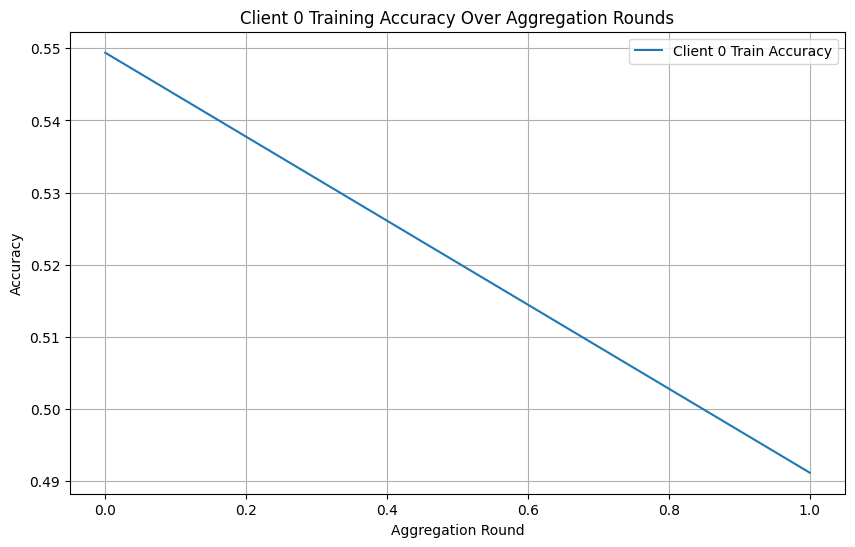

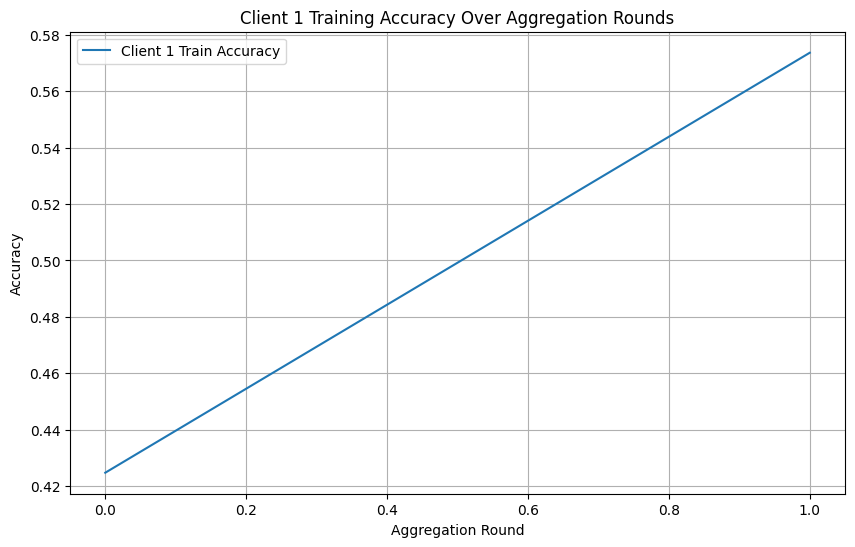

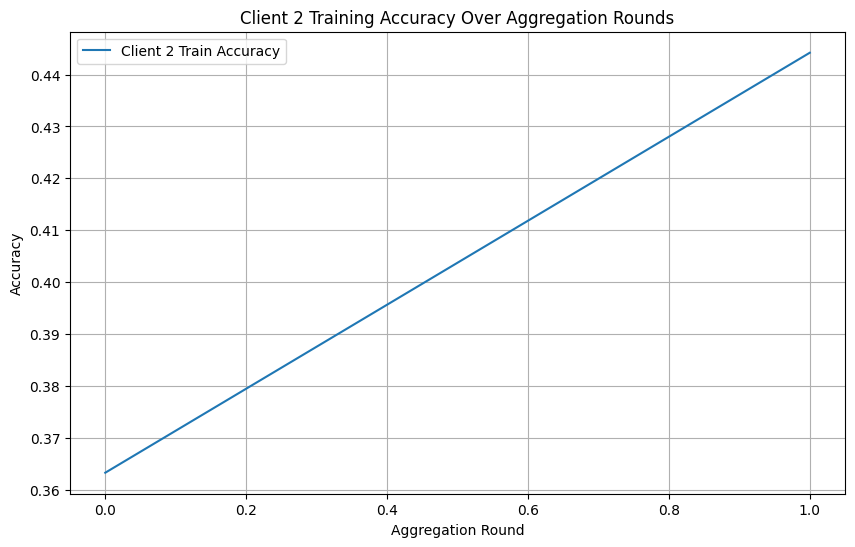

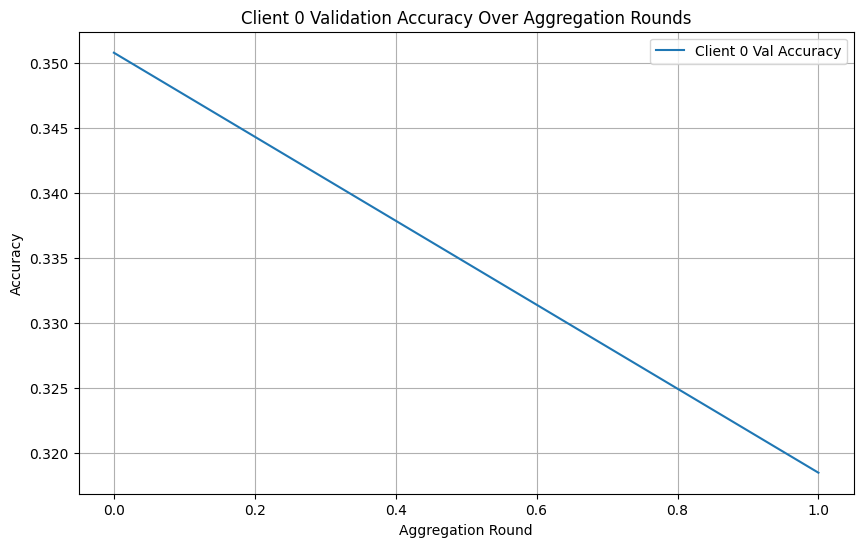

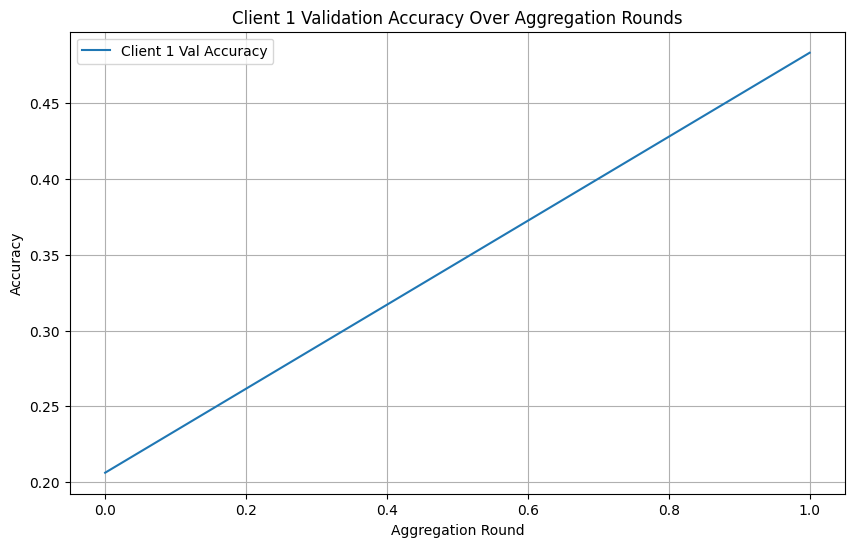

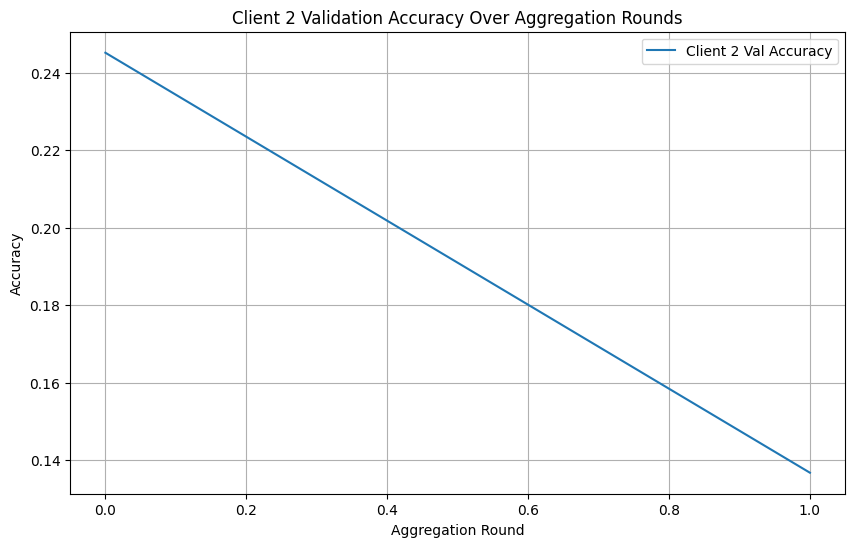

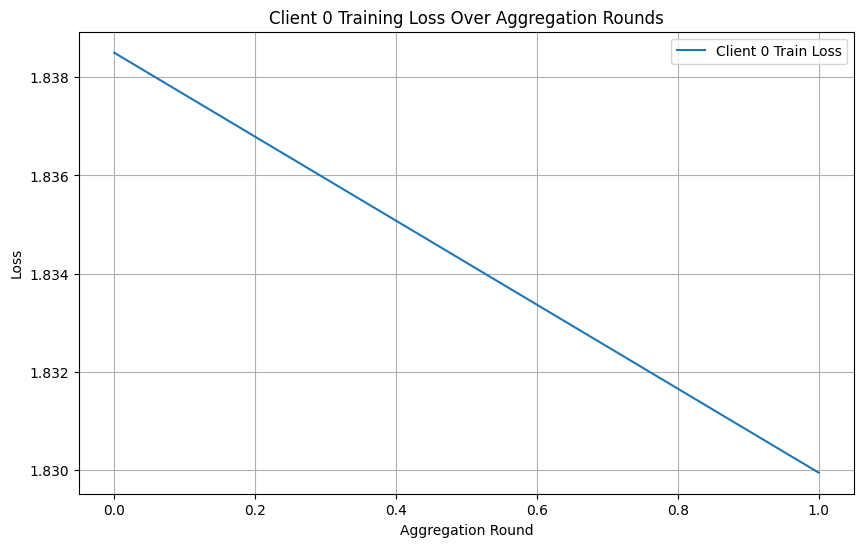

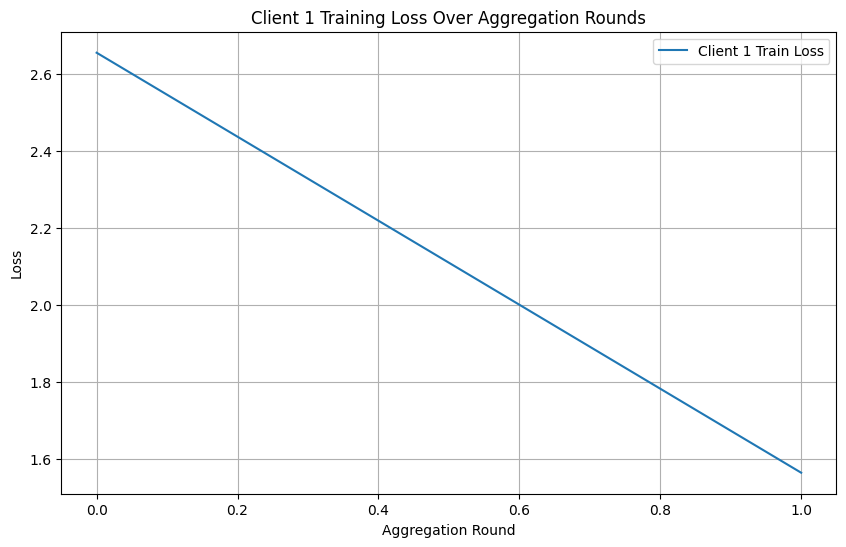

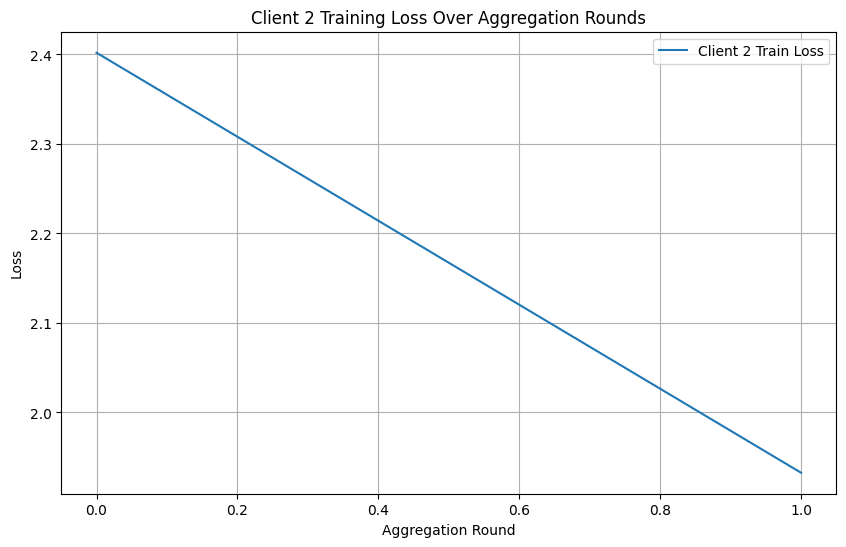

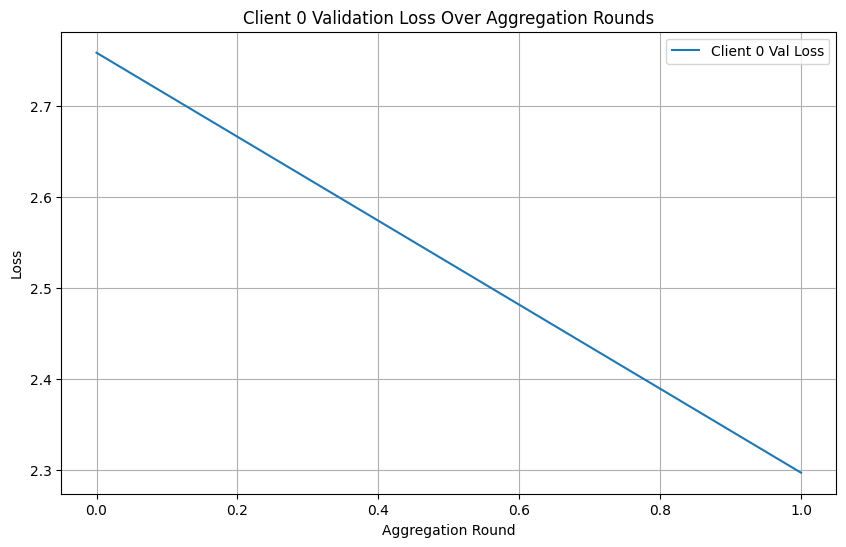

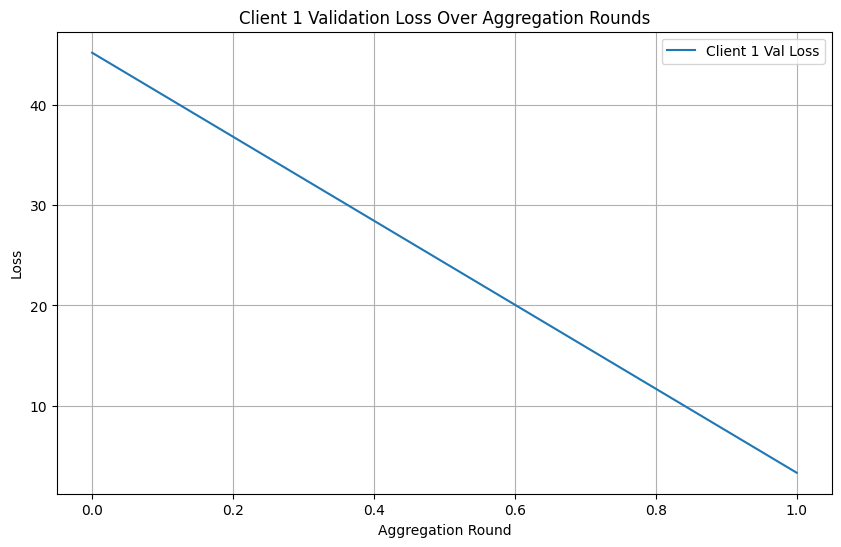

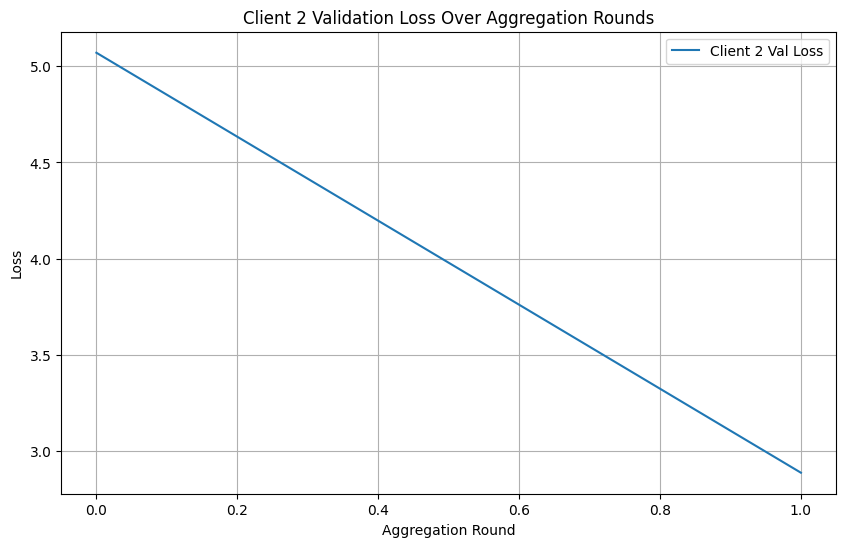

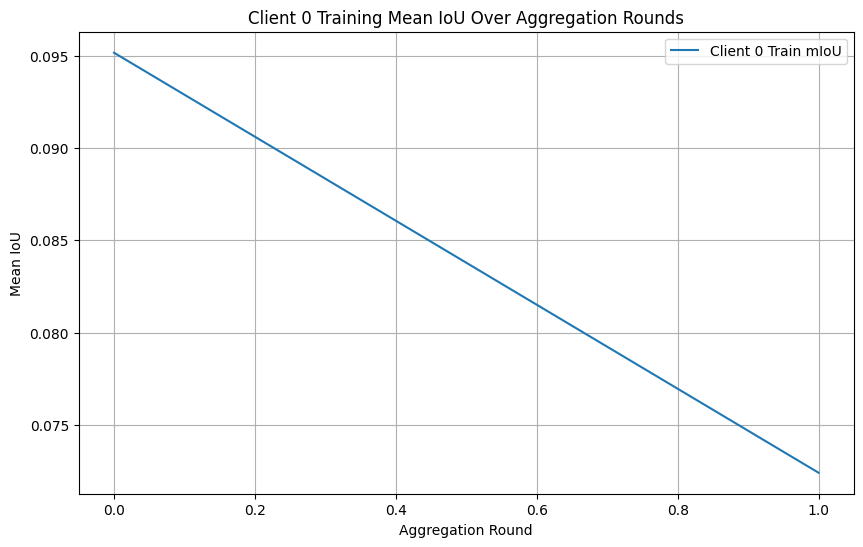

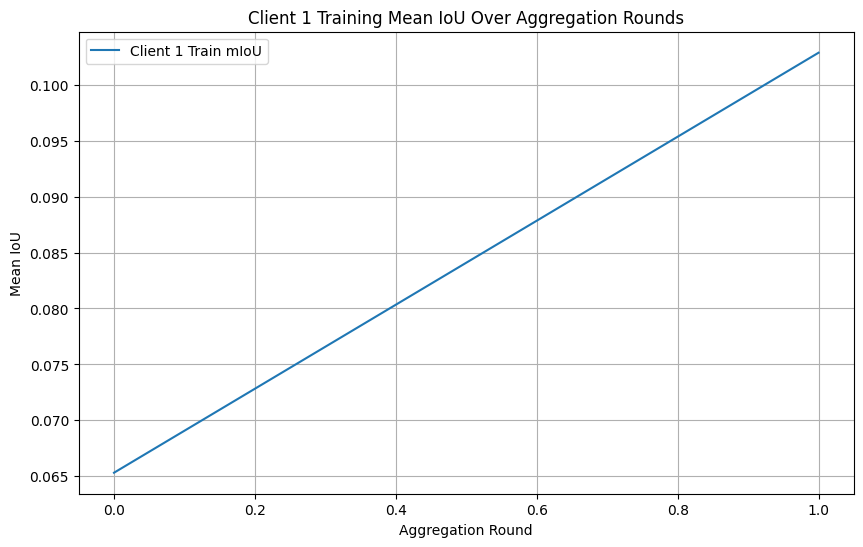

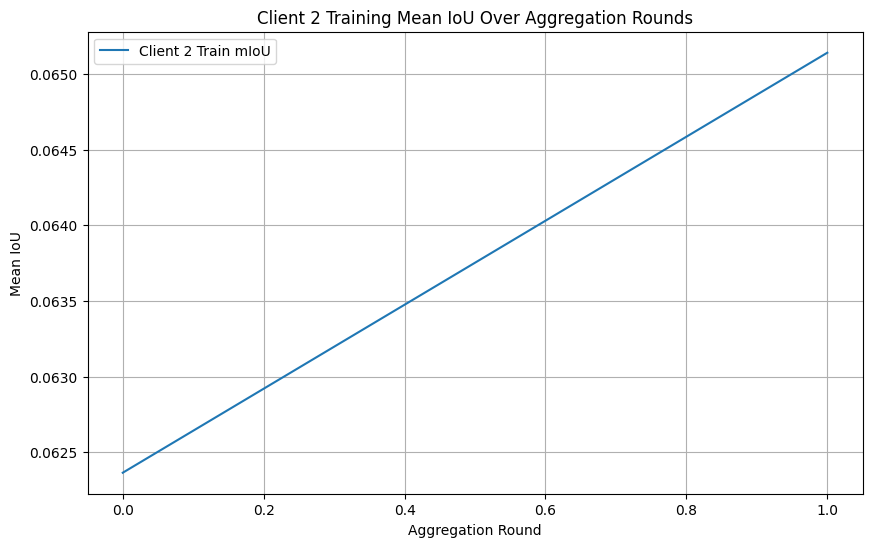

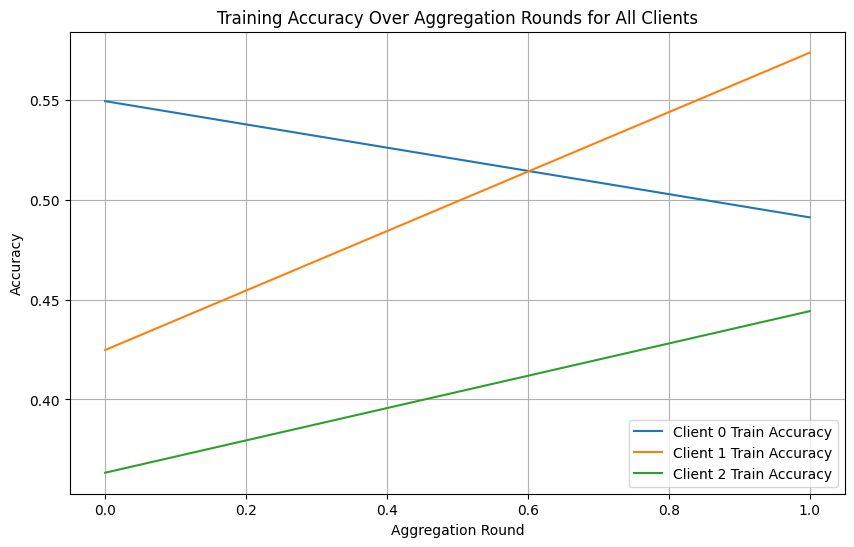

Aggregation Round 1 histories:
  Client 0: {'train_loss': [1.8384991863778992], 'val_loss': [2.7590017252498202], 'train_miou': [0.0951574503752806], 'val_miou': [0.051845000479946377], 'train_acc': [0.5493812493036988], 'val_acc': [0.3507924145575068], 'lrs': [0.0003999999999999993, 0.00042700970536526696, 0.0005077348530511047, 0.0006412669587014461, 0.0008261032461369475, 0.001060163559664094, 0.001340813774238685, 0.0016648954400247402, 0.0020287613277276094, 0.0024283164746725684, 0.0028590642696945546, 0.0033161570581976144, 0.003794450697872558, 0.004288562451100344, 0.004792931562517556, 0.005301881840001393, 0.005809685534785018, 0.006310627801793639, 0.006799071014761876, 0.007269518212327256, 0.007716674961074713, 0.008135508939322678, 0.008521306571092223, 0.008869726072898045, 0.009176846316370443, 0.009439210956806126, 0.009653867331023245, 0.009818399686762477, 0.009930956369669001, 0.0099902706618919, 0.009999225626708713, 0.009990516681618647, 0.009972147738762083, 0.0

In [ ]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store accuracies, losses, and mIoU for each client
train_accuracies = {i: [] for i in range(no_clients)}
val_accuracies = {i: [] for i in range(no_clients)}
train_losses = {i: [] for i in range(no_clients)}
val_losses = {i: [] for i in range(no_clients)}
train_miou = {i: [] for i in range(no_clients)}
val_miou = {i: [] for i in range(no_clients)}

# Populate the dictionaries with data from histories
for epoch_histories in histories:
	for i, history in enumerate(epoch_histories):
		train_accuracies[i].append(history["train_acc"][-1])
		val_accuracies[i].append(history["val_acc"][-1])
		train_losses[i].append(history["train_loss"][-1])
		val_losses[i].append(history["val_loss"][-1])
		train_miou[i].append(history["train_miou"][-1])
		val_miou[i].append(history["val_miou"][-1])

# Plotting training accuracy for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Accuracy")
	plt.title(f"Client {i} Training Accuracy Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting validation accuracy for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(val_accuracies[i], label=f"Client {i} Val Accuracy")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Accuracy")
	plt.title(f"Client {i} Validation Accuracy Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting training loss for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_losses[i], label=f"Client {i} Train Loss")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Loss")
	plt.title(f"Client {i} Training Loss Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting validation loss for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(val_losses[i], label=f"Client {i} Val Loss")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Loss")
	plt.title(f"Client {i} Validation Loss Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting mean IoU for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_miou[i], label=f"Client {i} Train mIoU")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Mean IoU")
	plt.title(f"Client {i} Training Mean IoU Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting all clients together for training accuracy
plt.figure(figsize=(10, 6))
for i in range(no_clients):
	plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
plt.xlabel("Aggregation Round")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Aggregation Rounds for All Clients")
plt.legend()
plt.grid(True)
plt.show()

# Display the detailed history for each client and each aggregation round
for e, epoch_histories in enumerate(histories):
	print(f"Aggregation Round {e+1} histories:")
	for i, history in enumerate(epoch_histories):
		print(f"  Client {i}: {history}")

In [ ]:
class DroneTestDataset(Dataset):

	def __init__(self, img_path, mask_path, X, transform=None):
		self.img_path = img_path
		self.mask_path = mask_path
		self.X = X
		self.transform = transform

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		img_full_path = os.path.join(self.img_path, self.X[idx] + ".jpg")
		mask_full_path = os.path.join(self.mask_path, self.X[idx] + ".png")

		img = cv2.imread(img_full_path)
		if img is None:
			raise FileNotFoundError(f"Image not found at {img_full_path}")

		mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
		if mask is None:
			raise FileNotFoundError(f"Mask not found at {mask_full_path}")

		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

		if self.transform is not None:
			aug = self.transform(image=img, mask=mask)
			img = Image.fromarray(aug["image"])
			mask = aug["mask"]

		if self.transform is None:
			img = Image.fromarray(img)

		mask = torch.from_numpy(mask).long()

		return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
def predict_image_mask_miou(
	model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
):
	model.eval()
	t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
	image = t(image)
	model.to(device)
	image = image.to(device)
	mask = mask.to(device)
	with torch.no_grad():

		image = image.unsqueeze(0)
		mask = mask.unsqueeze(0)

		output = model(image)
		score = mIoU(output, mask)
		masked = torch.argmax(output, dim=1)
		masked = masked.cpu().squeeze(0)
	return masked, score

In [ ]:
def predict_image_mask_pixel(
	model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
):
	model.eval()
	t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
	image = t(image)
	model.to(device)
	image = image.to(device)
	mask = mask.to(device)
	with torch.no_grad():

		image = image.unsqueeze(0)
		mask = mask.unsqueeze(0)

		output = model(image)
		acc = pixel_accuracy(output, mask)
		masked = torch.argmax(output, dim=1)
		masked = masked.cpu().squeeze(0)
	return masked, acc

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
	score_iou = []
	for i in tqdm(range(len(test_set))):
		img, mask = test_set[i]
		pred_mask, score = predict_image_mask_miou(model, img, mask)
		score_iou.append(score)
	return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


In [ ]:
def pixel_acc(model, test_set):
	accuracy = []
	for i in tqdm(range(len(test_set))):
		img, mask = test_set[i]
		pred_mask, acc = predict_image_mask_pixel(model, img, mask)
		accuracy.append(acc)
	return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


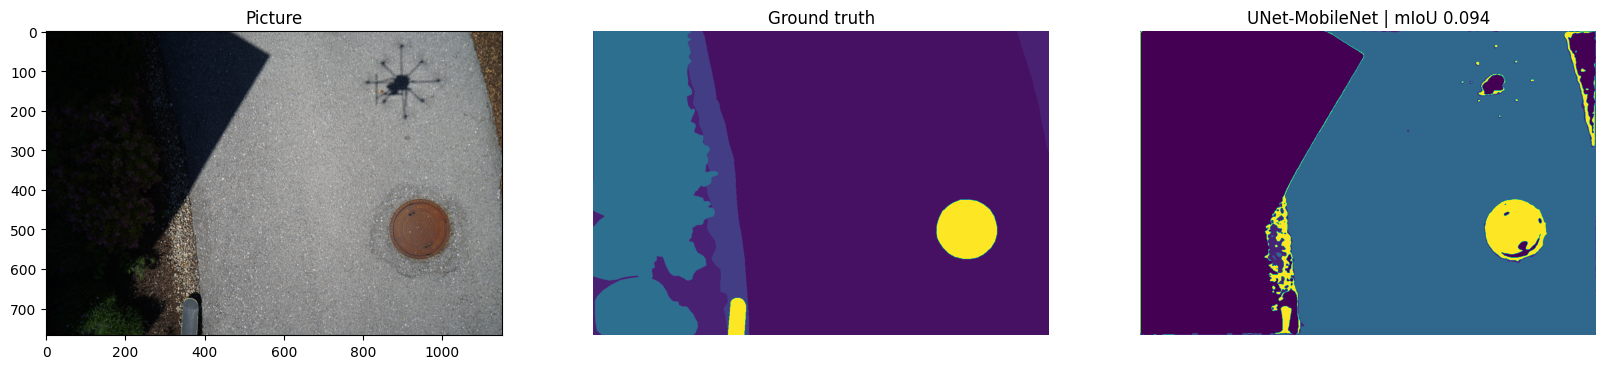

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title("Picture")

ax2.imshow(mask)
ax2.set_title("Ground truth")
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title("UNet-MobileNet | mIoU {:.3f}".format(score))
ax3.set_axis_off()

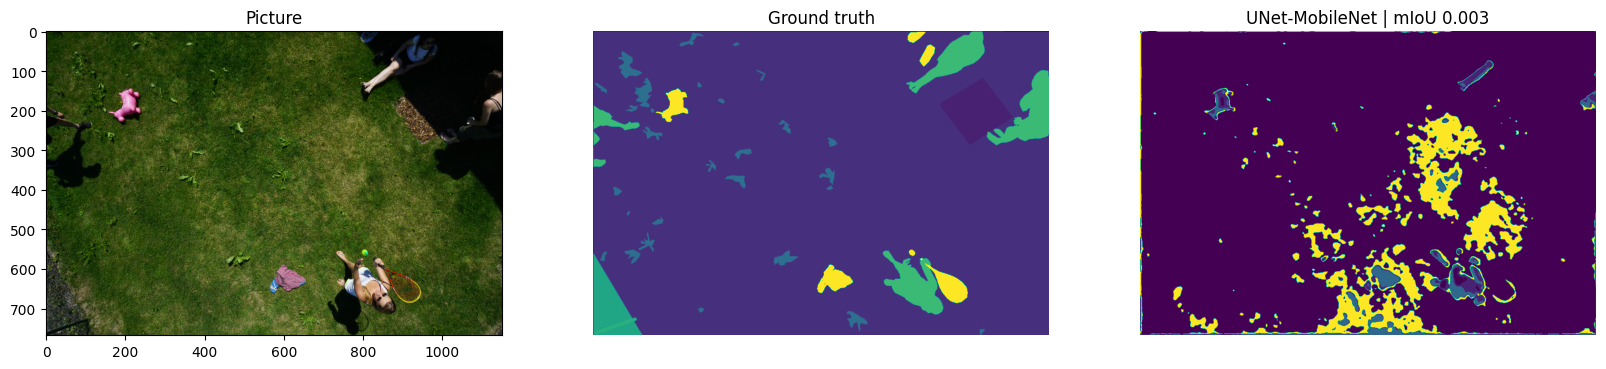

In [ ]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image3)
ax1.set_title("Picture")

ax2.imshow(mask3)
ax2.set_title("Ground truth")
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title("UNet-MobileNet | mIoU {:.3f}".format(score3))
ax3.set_axis_off()

In [ ]:
print("Test Set mIoU", np.mean(mob_miou))

Test Set mIoU 0.02281743372554173


In [ ]:
print("Test Set Pixel Accuracy", np.mean(mob_acc))

Test Set Pixel Accuracy 0.13302309954607927
